# 2021 JOISS 해양과학 빅데이터 활용 경진대회 : COD

## import

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf
!pip install statsmodels==0.12.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,156 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and d

In [1]:
! pip install googlemaps
! pip install xlrd

import io
import os
from google.colab import files
from google.colab import drive
import pandas as pd
import folium
import numpy as np
import googlemaps
import math
from folium.features import DivIcon
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
import random
from scipy.stats import expon, reciprocal
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from random import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose, STL


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 

  Created wheel for googlemaps: filename=googlemaps-4.5.3-py3-none-any.whl size=38479 sha256=43c69a2488cd750fc463ae809bf49c742cb4523f383c6463a6c135947fcccbe1
  Stored in directory: /root/.cache/pip/wheels/fa/1a/1c/cc0b8a1652a3f06aea586b0e4714a81bafed830513969baf92
Successfully built googlemaps


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df2015 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2015_profile_chemical.csv')
df2016 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2016_profile_chemical.csv')
df2017 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2017_profile_chemical.csv')
df2018 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2018_profile_chemical.csv')
df2019 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2019_profile_chemical.csv')
df2020 = pd.read_csv('/content/gdrive/MyDrive/해양/marin/해양환경측정망_2020_profile_chemical.csv')

## 데이터 정제

In [4]:
# 2015, 2016 오타 수정 
df2015.rename(columns = {'부유물질 농도[μg/L]' : '부유물질 농도[mg/L]'}, inplace = True)
df2016.rename(columns = {'부유물질 농도[μg/L]' : '부유물질 농도[mg/L]'}, inplace = True)

# 데이터 프레임 합치기
df = pd.concat([df2015,df2016, df2017, df2018, df2019, df2020], axis=0)

In [5]:
#화학적산소요구량 -> COD로 변환
df['COD'] = df['화학적산소요구량[mg/L]']

# 수심이 표층만 살려두기
df = df[df['수심(m)'] == 0]

# 필요없는 feature 삭제
df = df.drop(['화학적산소요구량[mg/L]', 'project_name','bot.depth[m]','수심(m)', '수심(text)', 'dep_flag', 'tn_qc', 'sal_qc', 'wtrtmp_qc', 'chla_qc', 'sussed_qc'
, 'disoxy_qc', 'hydioncon_qc', 'reasil_qc', 'nitnit_qc', 'po4p_qc', 'natnit_qc', 'tr_qc', 'disinon_qc'
, 'cheoxydem_qc', 'amn_qc', 'totp_qc','투명도[m]', '유효시간', '전체수심(m)', 'totdisn_qc'], axis=1)


In [6]:
# datetime 만들기
df.rename(columns={'yyyy-mm-dd hh:mm:ss':'date'}, inplace = True )
df['date'] = pd.to_datetime(df['date'])

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["hour"] = df["date"].dt.hour

df.shape

(9502, 23)

In [7]:
df.head()

,station,date,Longitude [degrees_east],Latitude [degrees_north],총질소[μg/L],염분[psu],수온[℃],클로로필-a[μg/L],부유물질 농도[mg/L],용존산소[mg/L],수소이온농도[무단위],규산염[μg/L],아질산성질소[μg/L],인산염인[μg/L],질산성질소[μg/L],용존무기질소[μg/L],암모니아성 질소[μg/L],총인[μg/L],COD,year,month,day,hour
0,가로림연안1_연안,2015-02-15,126.326944,36.946389,379.060,32.0841,3.5593,1.092,16.2,10.54070,8.17,375.600,1.792,24.025,190.232,194.012,1.988,41.7409,1.497090,2015,2,15,0
2,가로림연안1_연안,2015-05-10,126.326944,36.946389,407.890,31.9136,9.7594,3.220,13.6,10.34200,8.16,88.452,2.254,12.834,131.614,136.150,2.282,23.0668,1.044110,2015,5,10,0
4,가로림연안1_연안,2015-08-08,126.326944,36.946389,225.280,31.9163,21.6454,2.760,3.8,7.95450,8.04,142.940,14.392,8.959,37.800,58.338,6.146,24.2634,1.588370,2015,8,8,0
6,가로림연안1_연안,2015-11-12,126.326944,36.946389,315.545,31.9800,15.6163,0.904,20.6,8.31033,8.09,347.480,11.942,22.537,100.464,119.630,7.224,36.8339,0.855856,2015,11,12,0
8,가로림연안2_연안,2015-02-15,126.313333,36.990000,387.421,32.0735,3.7966,0.996,17.4,10.42260,8.17,384.500,1.834,24.614,197.204,201.292,2.254,42.4892,1.315460,2015,2,15,0


In [8]:
# 결측치 데이터 갯수 확인
df.isnull().sum()

station                     0
date                        0
Longitude [degrees_east]    0
Latitude [degrees_north]    0
총질소[μg/L]                   0
염분[psu]                     0
수온[℃]                       0
클로로필-a[μg/L]                0
부유물질 농도[mg/L]               0
용존산소[mg/L]                  0
수소이온농도[무단위]                 0
규산염[μg/L]                   0
아질산성질소[μg/L]                0
인산염인[μg/L]                  0
질산성질소[μg/L]                 0
용존무기질소[μg/L]                0
암모니아성 질소[μg/L]              0
총인[μg/L]                    0
COD                         0
year                        0
month                       0
day                         0
hour                        0
dtype: int64

In [9]:
# 결측치 데이터 시각화

# import missingno as msno
# msno.matrix(df, figsize=(12,8))

In [10]:
df.loc[df.month == 3].head()

,station,date,Longitude [degrees_east],Latitude [degrees_north],총질소[μg/L],염분[psu],수온[℃],클로로필-a[μg/L],부유물질 농도[mg/L],용존산소[mg/L],수소이온농도[무단위],규산염[μg/L],아질산성질소[μg/L],인산염인[μg/L],질산성질소[μg/L],용존무기질소[μg/L],암모니아성 질소[μg/L],총인[μg/L],COD,year,month,day,hour
746,낙동강하구3_환경관리,2017-03-23,128.908330,35.000000,460.4,29.91,25.06,1.44,11.4,4.82,8.04,787.8,20.5,26.4,145.0,272.3,106.8,48.0,1.60,2017,3,23,0
754,낙동강하구4_환경관리,2017-03-22,128.865280,34.995830,232.5,29.27,26.68,9.40,7.9,7.42,8.23,412.1,14.7,10.5,90.1,159.7,54.9,23.8,2.45,2017,3,22,0
616,기장연안1_연안,2019-03-05,129.280278,35.283333,103.8,34.50,14.53,2.94,11.7,9.60,8.34,84.7,2.5,3.8,10.9,14.3,1.0,16.6,0.27,2019,3,5,0
624,기장연안2_연안,2019-03-05,129.216667,35.166667,129.8,34.44,13.82,2.80,4.5,9.42,8.32,101.0,3.9,6.0,20.2,31.2,7.1,19.1,0.39,2019,3,5,0
632,기장연안3_연안,2019-03-05,129.291667,35.300000,99.5,34.45,15.01,2.22,4.8,9.49,8.33,107.4,3.0,5.0,14.7,19.9,2.2,13.5,0.43,2019,3,5,0


In [11]:
df['month'].unique()

array([ 2,  5,  8, 11,  3])

In [12]:
len(df.loc[df.month == 3])

47

In [13]:
# 3개월 간격이므로 3월 데이터 2월로 치환


df.loc[df.month == 3,'month']=2
df['month'].unique()

array([ 2,  5,  8, 11])

In [14]:
# 연안 갯수
len(df['station'].unique())

426

In [15]:
# 2015~2020 년도 확인
df['year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020])

In [16]:
#  2월 겨울 station 구역수 확인

for i in df['year'].unique():
  print(i, len(df.groupby(['year', 'month', 'station']).mean().loc[i, 2]))

2015 417
2016 413
2017 417
2018 425
2019 423
2020 421


In [17]:
# 연도별 8월 여름 station 구역수 확인
for i in df['year'].unique():
  print(i, len(df.groupby(['year', 'month', 'station']).mean().loc[i, 8]))

2015 416
2016 413
2017 415
2018 425
2019 425
2020 421


In [18]:
# 연도별 5월 봄 station 구역수 확인
for i in df['year'].unique():
  print(i, len(df.groupby(['year', 'month', 'station']).mean().loc[i, 5]))

2015 367
2016 363
2017 367
2018 375
2019 373
2020 386


In [19]:
# 연도별 11월 가을 station 구역수 확인
for i in df['year'].unique():
  print(i, len(df.groupby(['year', 'month', 'station']).mean().loc[i, 11]))

2015 367
2016 363
2017 367
2018 375
2019 375
2020 371


In [20]:
# 2월 데이터 프레임
df2 = df[df['month'] == 2]
# 8월 데이터 프레임
df8 = df[df['month'] == 8]
# 5월 데이터 프레임
df5 = df[df['month'] == 5]
# 11월 데이터 프레임
df11 = df[df['month'] == 11]

In [21]:
# 2월 데이터 프레임 station 중복 제거
for i in df['year'].unique():
  duplicate = df2[df2['year'] == i]['station'].unique() 
  df2 = df2[df2['station'].isin(duplicate)]
len(df2['station'].unique())

410

In [22]:
# 8월 데이터 프레임 station 중복 제거
for i in df['year'].unique():
  duplicate = df8[df8['year'] == i]['station'].unique() 
  df8 = df8[df8['station'].isin(duplicate)]
len(df8['station'].unique())

411

In [23]:
# 5월 데이터 프레임 station 중복 제거
for i in df['year'].unique():
  duplicate = df5[df5['year'] == i]['station'].unique() 
  df5 = df5[df5['station'].isin(duplicate)]
len(df5['station'].unique())

361

In [24]:
# 11월 데이터 프레임 station 중복 제거
for i in df['year'].unique():
  duplicate = df11[df11['year'] == i]['station'].unique() 
  df11 = df11[df11['station'].isin(duplicate)]
len(df11['station'].unique())

363

In [25]:
# 8월 데이터프레임에 2월에 없는 도암만3, 도암만5 제거
df8[df8['station'].isin(df2['station'].unique()) == False]['station'].unique()

array(['도암만3_환경관리', '도암만5_환경관리'], dtype=object)

In [26]:
# 2월 데이터프레임에 8월에 없는 영일만H1 제거
df2[df2['station'].isin(df8['station'].unique()) == False]['station'].unique()

array(['영일만H1_항만'], dtype=object)

In [27]:
# 5월 데이터프레임은 11월을 모두 내포
df5[df5['station'].isin(df11['station'].unique()) == False]['station'].unique()

array([], dtype=object)

In [28]:
# 11월 데이터프레임에 5월에 없는 도암만3, 도암만5 제거
df11[df11['station'].isin(df5['station'].unique()) == False]['station'].unique()

array(['도암만3_환경관리', '도암만5_환경관리'], dtype=object)

In [29]:
# 2월 8월 합친 데이터 프레임 df28 생성
df2 = df2[df2['station'].isin(df8['station'].unique())]
df8 = df8[df8['station'].isin(df2['station'].unique())]
df28 = pd.concat([df2,df8], axis=0)
df28 = df28.sort_values(['year', 'month'])
print(len(df28['station'].unique()))

409


In [30]:
# 5월 11월 합친 데이터 프레임 df511 생성
df5 = df5[df5['station'].isin(df11['station'].unique())]
df11 = df11[df11['station'].isin(df5['station'].unique())]
df511 = pd.concat([df5,df11], axis=0)
df511 = df511.sort_values(['year', 'month'])
print(len(df511['station'].unique()))

361


## 2월 8월 겨울 여름 데이터 분석

### Feature 선별

#### Feature들간 상관관계

In [31]:
df_corr28 = df28.drop(columns=['station', 'date', 'Longitude [degrees_east]','Latitude [degrees_north]','year', 'month', 'day', 'hour'],axis=1)
scaler= MinMaxScaler()
df_corr28[df_corr28.columns] = scaler.fit_transform(df_corr28[df_corr28.columns])
corr28 = df_corr28.corr(method= 'pearson')

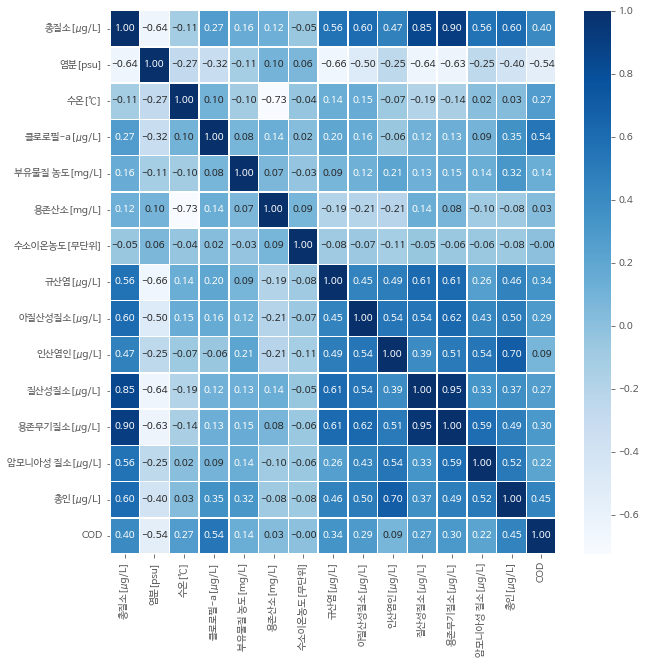

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns    
plt.figure(figsize=(10,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

# 변수들간 상관관계가 높은 총질소와 용존무기질소 모델링에서 제외

#### COD와 Feature 상관관계

In [33]:
df_corr28 = df28.drop(columns=['총질소[μg/L]', '용존무기질소[μg/L]', 'station', 'date', 'Longitude [degrees_east]','Latitude [degrees_north]','year', 'month', 'day', 'hour'],axis=1)
scaler= MinMaxScaler()
df_corr28[df_corr28.columns] = scaler.fit_transform(df_corr28[df_corr28.columns])
corr28 = df_corr28.corr(method= 'pearson')

In [34]:
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['COD'].sort_values(ascending=False), columns=['COD'])
df_temp28.style.background_gradient(cmap='viridis')

#0.1미만인 인산염인, 용존산소, 수소이온농도 모델링에서 제외

,COD
COD,1.000000
클로로필-a[μg/L],0.535298
총인[μg/L],0.449746
규산염[μg/L],0.337085
아질산성질소[μg/L],0.291791
수온[℃],0.273420
질산성질소[μg/L],0.265726
암모니아성 질소[μg/L],0.215240
부유물질 농도[mg/L],0.143133
인산염인[μg/L],0.086831


--> 총질소, 용존무기질소 인산염인, 용존산소, 수소이온농도 모델링에서 제외

In [35]:
df28 = df28.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '인산염인[μg/L]', '용존산소[mg/L]', '수소이온농도[무단위]'], axis = 1)

In [36]:
df28.head()

,station,date,Longitude [degrees_east],Latitude [degrees_north],염분[psu],수온[℃],클로로필-a[μg/L],부유물질 농도[mg/L],규산염[μg/L],아질산성질소[μg/L],질산성질소[μg/L],암모니아성 질소[μg/L],총인[μg/L],COD,year,month,day,hour
0,가로림연안1_연안,2015-02-15,126.326944,36.946389,32.0841,3.5593,1.092,16.2,375.6,1.792,190.232,1.988,41.7409,1.49709,2015,2,15,0
8,가로림연안2_연안,2015-02-15,126.313333,36.990000,32.0735,3.7966,0.996,17.4,384.5,1.834,197.204,2.254,42.4892,1.31546,2015,2,15,0
16,가로림연안3_연안,2015-02-15,126.200000,36.941667,32.0572,3.8867,1.088,20.8,383.9,1.708,197.330,2.828,43.9692,1.49709,2015,2,15,0
24,가로림연안4_연안,2015-02-15,126.333611,36.922500,32.0980,3.4265,1.020,15.2,368.7,1.890,168.588,2.422,40.5083,1.43104,2015,2,15,0
32,가로림연안5_연안,2015-02-15,126.322500,36.970833,32.0889,3.6491,0.924,10.6,374.1,1.386,174.818,1.960,36.3168,1.24941,2015,2,15,0


#### 시각화

Text(0.5, 1.0, '2020년 8월 COD 농도')

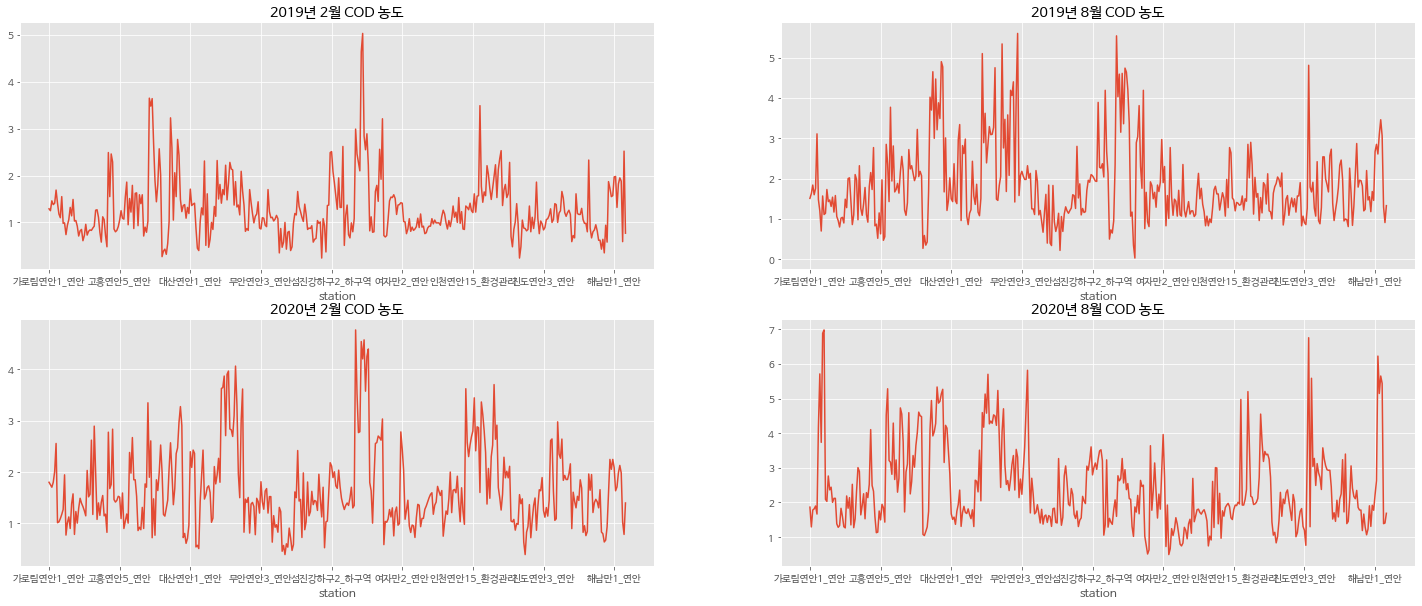

In [37]:
# 그래프 시각화

#19/20년도 2/8월 COD 농도 station 별로 보기
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(25,10)

df28.groupby(['year', 'month', 'station']).mean().loc[2019, 2]['COD'].plot(ax=ax1)
ax1.set_title("2019년 2월 COD 농도")
df28.groupby(['year', 'month', 'station']).mean().loc[2019, 8]['COD'].plot(ax=ax2)
ax2.set_title("2019년 8월 COD 농도")
df28.groupby(['year', 'month', 'station']).mean().loc[2020, 2]['COD'].plot(ax=ax3)
ax3.set_title("2020년 2월 COD 농도")
df28.groupby(['year', 'month', 'station']).mean().loc[2020, 8]['COD'].plot(ax=ax4)
ax4.set_title("2020년 8월 COD 농도")

In [63]:
"# # 그래프 시각화

# #19/20년도 5/11월 COD 농도 station 별로 보기
# figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
# figure.set_size_inches(25,10)

# df511.groupby(['year', 'month', 'station']).mean().loc[2019, 5]['COD'].plot(ax=ax1)
# ax1.set_title("2019년 5월 COD 농도")
# df511.groupby(['year', 'month', 'station']).mean().loc[2019, 11]['COD'].plot(ax=ax2)
# ax2.set_title("2019년 11월 COD 농도")
# df511.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['COD'].plot(ax=ax3)
# ax3.set_title("2020년 5월 COD 농도")
# df511.groupby(['year', 'month', 'station']).mean().loc[2020, 11]['COD'].plot(ax=ax4)
# ax4.set_title("2020년 11월 COD 농도")

In [ ]:
df28

,station,date,Longitude [degrees_east],Latitude [degrees_north],염분[psu],수온[℃],클로로필-a[μg/L],부유물질 농도[mg/L],규산염[μg/L],아질산성질소[μg/L],질산성질소[μg/L],암모니아성 질소[μg/L],총인[μg/L],COD,year,month,day,hour
0,가로림연안1_연안,2015-02-15 00:00:00,126.326944,36.946389,32.0841,3.5593,1.092,16.20,375.600,1.792,190.232,1.988,41.7409,1.49709,2015,2,15,0
8,가로림연안2_연안,2015-02-15 00:00:00,126.313333,36.990000,32.0735,3.7966,0.996,17.40,384.500,1.834,197.204,2.254,42.4892,1.31546,2015,2,15,0
16,가로림연안3_연안,2015-02-15 00:00:00,126.200000,36.941667,32.0572,3.8867,1.088,20.80,383.900,1.708,197.330,2.828,43.9692,1.49709,2015,2,15,0
24,가로림연안4_연안,2015-02-15 00:00:00,126.333611,36.922500,32.0980,3.4265,1.020,15.20,368.700,1.890,168.588,2.422,40.5083,1.43104,2015,2,15,0
32,가로림연안5_연안,2015-02-15 00:00:00,126.322500,36.970833,32.0889,3.6491,0.924,10.60,374.100,1.386,174.818,1.960,36.3168,1.24941,2015,2,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,행암만3_환경관리,2020-08-05 16:16:00,128.679720,35.144440,20.4961,27.4106,23.200,9.10,792.904,26.334,267.022,67.592,65.9370,5.65278,2020,8,5,16
3138,행암만4_환경관리,2020-08-05 16:03:00,128.687780,35.146110,24.7374,23.5298,34.920,9.10,789.432,14.154,118.062,87.948,78.0270,5.44040,2020,8,5,16
3146,후포연안1_연안,2020-08-17 13:46:00,129.458889,36.647500,32.1025,22.0892,0.810,6.45,82.712,0.140,1.694,3.276,8.8970,1.38667,2020,8,17,13
3154,후포연안2_연안,2020-08-17 12:27:00,129.483611,36.694444,32.3917,21.1699,0.940,11.30,81.536,0.210,4.046,6.104,9.1140,1.40331,2020,8,17,12


In [ ]:
df28.groupby('station').mean()['COD']

station
가로림연안1_연안    1.555842
가로림연안2_연안    1.406373
가로림연안3_연안    1.449887
가로림연안4_연안    1.415570
가로림연안5_연안    1.483668
               ...   
행암만3_환경관리    2.876080
행암만4_환경관리    2.795914
후포연안1_연안     0.992329
후포연안2_연안     1.113815
후포연안H1_항만    1.209134
Name: COD, Length: 409, dtype: float64

In [ ]:
df28.groupby('station').mean()['총인[μg/L]']

station
가로림연안1_연안    33.312275
가로림연안2_연안    35.045867
가로림연안3_연안    35.266742
가로림연안4_연안    32.141817
가로림연안5_연안    33.575100
               ...    
행암만3_환경관리    34.241125
행암만4_환경관리    38.596633
후포연안1_연안     14.043317
후포연안2_연안     16.293550
후포연안H1_항만    15.801200
Name: 총인[μg/L], Length: 409, dtype: float64

In [70]:
# COD와 총인 지도 시각화 (연안1)

m = folium.Map(location=[36.377247, 128.067197], zoom_start=7, prefer_canvas=True)

for i in df28.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    if '1' in i:
      if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
        folium.Circle(location=df28.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                    radius=float(df28.groupby('station').mean()['COD'].loc[i])*5000, 
                    color='#FF3333', fill_color='#FF3333', fill_opacity=0.2, line_opcity=0.2, 
                    tooltip=int(df28.groupby('station').mean()['COD'].loc[i])).add_to(m)

for i in df28.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    if '1' in i:
      if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
        folium.Circle(location=df28.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                    radius=float(df28.groupby('station').mean()['클로로필-a[μg/L]'].loc[i])*2000, 
                    color='#9933FF', fill_color='#9933FF', fill_opacity=0.2, line_opcity=0.2, 
                    tooltip=int(df28.groupby('station').mean()['클로로필-a[μg/L]'].loc[i])).add_to(m)


m

### df28 모델링

#### 모델링 데이터프레임 만들기 
sm28 : 년/월/구역 별 테이블

learn28/predict28 : 학습시킬 테이블과 예측시킬 테이블

learn28_sc/predict28_sc : 스케일링된 독립변수 테이블

In [38]:
feature = df.columns[4:19]
total28 = feature.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '인산염인[μg/L]', '용존산소[mg/L]', '수소이온농도[무단위]'])
ft28 = feature.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '인산염인[μg/L]', '용존산소[mg/L]', '수소이온농도[무단위]', 'COD'])
target = 'COD'
ft28

Index(['염분[psu]', '수온[℃]', '클로로필-a[μg/L]', '부유물질 농도[mg/L]', '규산염[μg/L]',
       '아질산성질소[μg/L]', '질산성질소[μg/L]', '암모니아성 질소[μg/L]', '총인[μg/L]'],
      dtype='object')

In [39]:
len(ft28) #COD 빼줘야함

9

In [40]:
sm28 = df28.groupby(['year', 'month', 'station'])[total28].mean()

In [41]:
sm28

염분[psu]    수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  \
year month station                                                    
2015 2     가로림연안1_연안  32.0841   3.5593         1.092          16.20   
           가로림연안2_연안  32.0735   3.7966         0.996          17.40   
           가로림연안3_연안  32.0572   3.8867         1.088          20.80   
           가로림연안4_연안  32.0980   3.4265         1.020          15.20   
           가로림연안5_연안  32.0889   3.6491         0.924          10.60   
...                       ...      ...           ...            ...   
2020 8     행암만3_환경관리  20.4961  27.4106        23.200           9.10   
           행암만4_환경관리  24.7374  23.5298        34.920           9.10   
           후포연안1_연안   32.1025  22.0892         0.810           6.45   
           후포연안2_연안   32.3917  21.1699         0.940          11.30   
           후포연안H1_항만  31.8048  21.0931         1.752           5.55   

                      규산염[μg/L]  아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  \
year month station                                                           
2015 2     가로림연안1_연안    375.600         1.792      190.232           1.988   
           가로림연안2_연안    384.500         1.834      197.204           2.254   
           가로림연안3_연안    383.900         1.708      197.330           2.828   
           가로림연안4_연안    368.700         1.890      168.588           2.422   
           가로림연안5_연안    374.100         1.386      174.818           1.960   
...                         ...           ...          ...             ...   
2020 8     행암만3_환경관리    792.904        26.334      267.022          67.592   
           행암만4_환경관리    789.432        14.154      118.062          87.948   
           후포연안1_연안      82.712         0.140        1.694           3.276   
           후포연안2_연안      81.536         0.210        4.046           6.104   
           후포연안H1_항만     94.164         0.084        2.338          20.874   

                      총인[μg/L]      COD  
year month station                       
2015 2     가로림연안1_연안   41.7409  1.49709  
           가로림연안2_연안   42.4892  1.31546  
           가로림연안3_연안   43.9692  1.49709  
           가로림연안4_연안   40.5083  1.43104  
           가로림연안5_연안   36.3168  1.24941  
...                        ...      ...  
2020 8     행암만3_환경관리   65.9370  5.65278  
           행암만4_환경관리   78.0270  5.44040  
           후포연안1_연안     8.8970  1.38667  
           후포연안2_연안     9.1140  1.40331  
           후포연안H1_항만   14.0740  1.68619  

[4908 rows x 10 columns]

In [42]:
#2월 -> 2월 12개월씩 shift된 yhat
sm28['yhat'] = sm28['COD'].shift(-818)
sm28.head(819)

염분[psu]    수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  \
year month station                                                    
2015 2     가로림연안1_연안  32.0841   3.5593        1.0920        16.2000   
           가로림연안2_연안  32.0735   3.7966        0.9960        17.4000   
           가로림연안3_연안  32.0572   3.8867        1.0880        20.8000   
           가로림연안4_연안  32.0980   3.4265        1.0200        15.2000   
           가로림연안5_연안  32.0889   3.6491        0.9240        10.6000   
...                       ...      ...           ...            ...   
     8     행암만4_환경관리  31.2908  28.6313       21.3633        15.6667   
           후포연안1_연안   33.5670  22.8065        0.1796         4.6000   
           후포연안2_연안   33.3974  23.3034        0.3280         1.6000   
           후포연안H1_항만  34.1844   9.5843        0.5540         1.1000   
2016 2     가로림연안1_연안  32.0500   3.8800        2.4200         9.4000   

                      규산염[μg/L]  아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  \
year month station                                                           
2015 2     가로림연안1_연안    375.600         1.792      190.232          1.9880   
           가로림연안2_연안    384.500         1.834      197.204          2.2540   
           가로림연안3_연안    383.900         1.708      197.330          2.8280   
           가로림연안4_연안    368.700         1.890      168.588          2.4220   
           가로림연안5_연안    374.100         1.386      174.818          1.9600   
...                         ...           ...          ...             ...   
     8     행암만4_환경관리     53.032         7.322       13.356         83.3187   
           후포연안1_연안       9.200         0.140        1.624          4.7460   
           후포연안2_연안      14.560         0.112        3.486          2.3240   
           후포연안H1_항만    224.900         2.646       72.590          8.0500   
2016 2     가로림연안1_연안    472.900         1.100      179.200          3.4000   

                      총인[μg/L]       COD  yhat  
year month station                              
2015 2     가로림연안1_연안   41.7409  1.497090  1.21  
           가로림연안2_연안   42.4892  1.315460  1.38  
           가로림연안3_연안   43.9692  1.497090  1.23  
           가로림연안4_연안   40.5083  1.431040  1.04  
           가로림연안5_연안   36.3168  1.249410  1.47  
...                        ...       ...   ...  
     8     행암만4_환경관리   44.2754  4.028780  4.02  
           후포연안1_연안    13.7200  1.022540  0.98  
           후포연안2_연안    10.5254  0.747574  1.08  
           후포연안H1_항만   17.1238  0.412600  1.45  
2016 2     가로림연안1_연안   43.4000  1.210000  1.59  

[819 rows x 11 columns]

In [43]:
#학습시킬 테이블과 (COD yhat을) 예측시킬 테이블 나누기 (기존 y(COD) 는 삭제)
learn28 = sm28[sm28['yhat'].notnull()]
learn28 = learn28.drop(['COD'], axis=1)

predict28 = sm28[sm28['yhat'].isnull()]
predict28 = predict28.drop(["COD"], axis=1)

predict28.head()

염분[psu]   수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  규산염[μg/L]  \
year month station                                                              
2020 2     가로림연안1_연안  31.7594  5.5484         1.740          22.60    367.332   
           가로림연안2_연안  31.8122  5.7934         1.292          40.30    391.300   
           가로림연안3_연안  31.8133  5.8103         1.000          35.50    399.168   
           가로림연안4_연안  31.7089  5.3150         3.760           6.65    323.148   
           가로림연안5_연안  31.8108  5.7913         1.428          51.31    389.732   

                      아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                          
2020 2     가로림연안1_연안         1.470      137.298           4.312    39.153   
           가로림연안2_연안         1.484      163.170           4.676    49.476   
           가로림연안3_연안         1.106      176.554           2.478    50.251   
           가로림연안4_연안         1.344       87.304           2.730    29.667   
           가로림연안5_연안         1.372      163.478           4.158    47.492   

                      yhat  
year month station          
2020 2     가로림연안1_연안   NaN  
           가로림연안2_연안   NaN  
           가로림연안3_연안   NaN  
           가로림연안4_연안   NaN  
           가로림연안5_연안   NaN

In [44]:
# 독립변수만 스케일링

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

learn_sc28 = sc.fit_transform(learn28.loc[:, ft28])
learn_sc28 = pd.DataFrame(learn_sc28, columns=[ft28], index=learn28.loc[:, ft28].index)

predict_sc28 = sc.fit_transform(predict28.loc[:, ft28])
predict_sc28 = pd.DataFrame(predict_sc28, columns=[ft28], index=predict28.loc[:, ft28].index)

learn_sc28.head()

염분[psu]     수온[℃] 클로로필-a[μg/L] 부유물질 농도[mg/L] 규산염[μg/L]  \
year month station                                                              
2015 2     가로림연안1_연안  0.925198  0.141433     0.008411      0.076826  0.111175   
           가로림연안2_연안  0.924892  0.148714     0.007672      0.082518  0.113812   
           가로림연안3_연안  0.924420  0.151479     0.008380      0.098648  0.113634   
           가로림연안4_연안  0.925600  0.137358     0.007856      0.072082  0.109130   
           가로림연안5_연안  0.925337  0.144188     0.007117      0.050259  0.110730   

                     아질산성질소[μg/L] 질산성질소[μg/L] 암모니아성 질소[μg/L]  총인[μg/L]  
year month station                                                      
2015 2     가로림연안1_연안     0.010554    0.091088       0.000769  0.160354  
           가로림연안2_연안     0.010801    0.094426       0.000872  0.163629  
           가로림연안3_연안     0.010059    0.094487       0.001094  0.170106  
           가로림연안4_연안     0.011131    0.080724       0.000937  0.154960  
           가로림연안5_연안     0.008163    0.083707       0.000758  0.136616

#### 모델링

In [45]:
import tensorflow as tf
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
#import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
#import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [46]:
X = learn_sc28
y = learn28['yhat']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=12345678)

##### 랜덤 포레스트
여러 개의 결정트리(Decision Tree)를 활용한 '배깅' 방식의 대표적인 알고리즘
(배깅(Bagging)은 Bootstrap Aggregating의 약자로,
보팅(Voting)과는 달리 동일한 알고리즘으로 여러 분류기를 만들어 보팅으로 최종 결정하는 알고리즘)

랜덤포레스트는 dataset의 다양한 하위 sample에 대한 여러 개의 Decision Tree에서의 평균을 사용하여 predict Accuracy를 높이고 overffing을 제어하는 meta estimator 이다.

In [50]:
#랜덤 포레스트

with tf.device('/device:GPU:0'):
  model = RandomForestRegressor()
  model.fit(X_train, y_train)

y_pred = model.predict(X_test)
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('R2 :' , R2) 
print('MAE :', MAE) 

R2 : 0.599939330976891
MAE : 0.3850762722071836


##### 하이퍼 파리미터 튜닝

In [51]:
#하이퍼 파리미터 튜닝
from sklearn.model_selection import GridSearchCV

params =[
        {'n_estimators': [50, 80, 100], 'max_features': [5, 6, 7, 8, 9]}
    ]

rf_model28 = RandomForestRegressor()
rf_model28 = GridSearchCV(rf_model28, param_grid=params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
rf_model28.fit(X_train,y_train)
rf_model28.best_params_

{'max_features': 5, 'n_estimators': 100}

In [ ]:
cvres = rf_model28.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(round(np.sqrt(-mean_score),3), params)

0.576 {'max_features': 5, 'n_estimators': 100}


이때 RMSE 점수 : 0.575 {'max_features': 5, 'n_estimators': 100}

In [55]:
y_pred28 = rf_model28.predict(X_test)
R2 = r2_score(y_test, y_pred28)
MAE = mean_absolute_error(y_test, y_pred28)
R2

0.6041649385958785

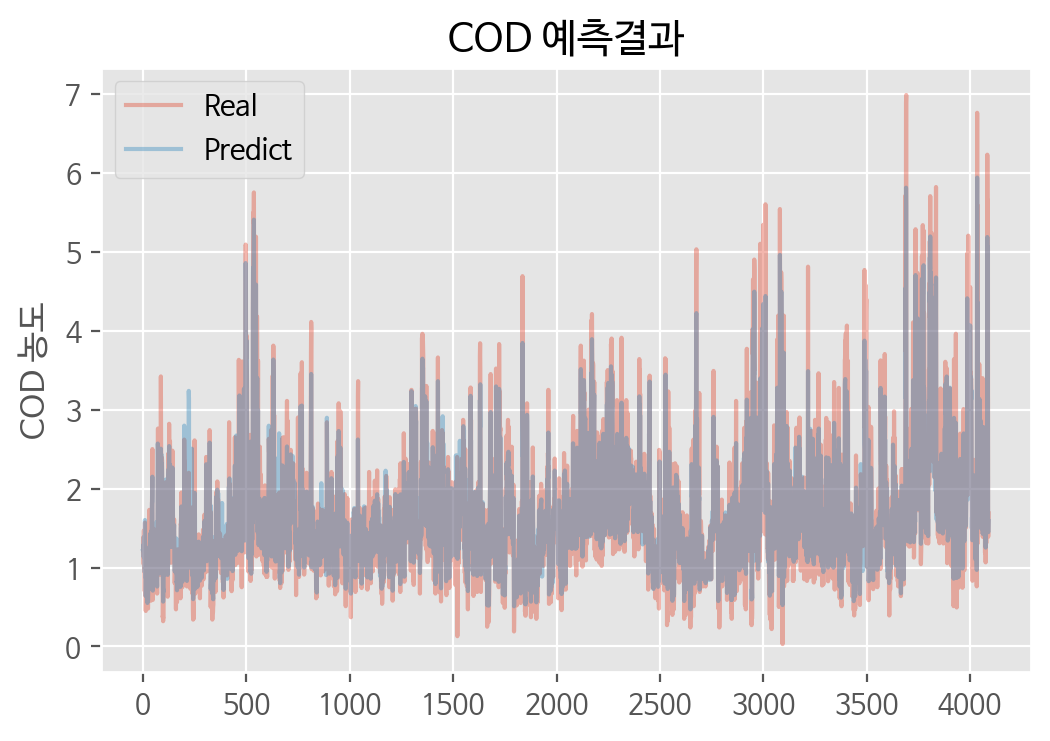

In [53]:
plt.figure(dpi=200)
plt.title('COD 예측결과')
plt.ylabel('COD 농도')
plt.plot(np.array(y), alpha = 0.4, label = 'Real')
plt.plot(rf_model28.predict(X), alpha = 0.4, label = 'Predict')
plt.legend()
plt.show()

In [ ]:
#COD 평균 값 
sm28['COD'].mean() #1.63 에서 +- 0.39정도 차이남

1.630819309820703

In [ ]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error 
# from sklearn.metrics import mean_squared_log_error
# #MAE를 퍼센트로 변환
# def MAPE(y_test, y_pred):
# 	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
# def MPE(y_test, y_pred): 
# 	return np.mean((y_test - y_pred) / y_test) * 100

# MAE = mean_absolute_error(y_test, y_pred)
# #MAE는 실제 관측값과 회귀식으로 예측한 값 차이를 제곱 합이 아닌 절대값의 합
# MSE = mean_squared_error(y_test, y_pred)
# #MSE는 SSE를 자유도로 나누어준 값이다. 
# #자유도를 나누어 줌으로써 MSE가 크다의 의미는 단순히 데이터가 많아서 크다는 것이 아니라(SSE는 데이터 수가 많아지면 커진다.) 실제 차이가 커서 크다고 판단할 수 있게 되는 것이다.

# RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(y_test, y_pred)    
# MAPE = MAPE(y_test, y_pred)
# #MAPE는 MAE에서 실제 관측값과 회귀식으로 예측한 값 차이를 회귀식으로 예측한 값으로 나눈 절대값의 합이다. 
# #MAE는 outlier에 취약할 수 있는데(한 없이 커질 수 있다는 의미이다.) MAPE는 최대 크기가 제한되므로 이를 보완한 개념
# MPE = MPE(y_test, y_pred)

# print('MAE : ', MAE)
# print('MSE : ', MSE)
# print('RMSE : ', RMSE)
# print('MSLE : ', MSLE)
# print('MAPE : ', MAPE)
# print('MPE : ', MPE)

MAE :  0.3819169262201653
MSE :  0.2633075994309333
RMSE :  0.513135069383231
MSLE :  0.03263964716787251
MAPE :  27.576331965063837
MPE :  -11.109337955597233


In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
import os
import glob

MAE = mean_absolute_error(y_test, y_pred28)
#MAE는 실제 관측값과 회귀식으로 예측한 값 차이를 제곱 합이 아닌 절대값의 합

MSE = mean_squared_error(y_test, y_pred28)
#MSE는 SSE를 자유도로 나누어준 값이다. 
#자유도를 나누어 줌으로써 MSE가 크다의 의미는 단순히 데이터가 많아서 크다는 것이 아니라(SSE는 데이터 수가 많아지면 커진다.) 실제 차이가 커서 크다고 판단할 수 있게 되는 것이다.

#MAPE는 MAE에서 실제 관측값과 회귀식으로 예측한 값 차이를 회귀식으로 예측한 값으로 나눈 절대값의 합이다. 
#SMAPE는 0이나 0에 근접한 데이터가 포함되는 경우엔 MAPE는 전체 오류율을 왜곡시키므로 이러한 경우엔 SMAPE가 더 적합한 방법으로 사용된다.
#Symmetric mean absolute percentage error (SMAPE 또는 sMAPE)는 백분율(퍼센티지, 또는 상대) 오류를 기반으로 한 정확도 측정 방법이다. 
#평균 절대 백분율 오차(MAPE, Mean absolute percentage error)와 달리 SMAPE엔 상한과 하한이 있다. 
#SMAPE의 이러한 값의 제한은 MAPE에서 발생하는 오류율의 왜곡을 막아준다. 
#SMAPE에도 한계가 있는데 실제 값 또는 예측 값이 0인 경우 오류 값이 오류의 상한값까지 상승한다는 것이다. 

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

SMAPE = smape(y_test, y_pred28)

print('MAE : ', MAE)
print('MSE : ', MSE)
print('SMAPE : ', SMAPE)

MAE :  0.38301266415997204
MSE :  0.2637747238331978
SMAPE :  23.909626128686096


### 12개월 이후 yhat 예측 (랜포)

In [ ]:
#12개월 후 값 예측하여 값 저장
newpred28 = rf_model28.predict(predict_sc28)

In [ ]:
#기존 yhat이 NaN 행에  예측 값 넣어주기
predict28['yhat'] = newpred28
predict28

염분[psu]    수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  \
year month station                                                    
2020 2     가로림연안1_연안  31.7594   5.5484         1.740          22.60   
           가로림연안2_연안  31.8122   5.7934         1.292          40.30   
           가로림연안3_연안  31.8133   5.8103         1.000          35.50   
           가로림연안4_연안  31.7089   5.3150         3.760           6.65   
           가로림연안5_연안  31.8108   5.7913         1.428          51.31   
...                       ...      ...           ...            ...   
     8     행암만3_환경관리  20.4961  27.4106        23.200           9.10   
           행암만4_환경관리  24.7374  23.5298        34.920           9.10   
           후포연안1_연안   32.1025  22.0892         0.810           6.45   
           후포연안2_연안   32.3917  21.1699         0.940          11.30   
           후포연안H1_항만  31.8048  21.0931         1.752           5.55   

                      규산염[μg/L]  아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  \
year month station                                                           
2020 2     가로림연안1_연안    367.332         1.470      137.298           4.312   
           가로림연안2_연안    391.300         1.484      163.170           4.676   
           가로림연안3_연안    399.168         1.106      176.554           2.478   
           가로림연안4_연안    323.148         1.344       87.304           2.730   
           가로림연안5_연안    389.732         1.372      163.478           4.158   
...                         ...           ...          ...             ...   
     8     행암만3_환경관리    792.904        26.334      267.022          67.592   
           행암만4_환경관리    789.432        14.154      118.062          87.948   
           후포연안1_연안      82.712         0.140        1.694           3.276   
           후포연안2_연안      81.536         0.210        4.046           6.104   
           후포연안H1_항만     94.164         0.084        2.338          20.874   

                      총인[μg/L]      yhat  
year month station                        
2020 2     가로림연안1_연안    39.153  1.682114  
           가로림연안2_연안    49.476  1.538183  
           가로림연안3_연안    50.251  1.681660  
           가로림연안4_연안    29.667  1.746782  
           가로림연안5_연안    47.492  1.619340  
...                        ...       ...  
     8     행암만3_환경관리    65.937  3.407967  
           행암만4_환경관리    78.027  3.325763  
           후포연안1_연안      8.897  1.439984  
           후포연안2_연안      9.114  1.301886  
           후포연안H1_항만    14.074  1.959189  

[818 rows x 10 columns]

#### yhat증감비율

In [ ]:
#2020년 2월
twenty = df28.groupby(['year', 'month', 'station']).mean().loc[2020, 2]['COD']
#2021년 2월
twentyone = predict28.groupby(['year', 'month', 'station']).mean().loc[2020, 2]['yhat']

In [ ]:
nt = pd.concat([twenty,twentyone], axis=1)
nt = nt.T.pct_change()*100
nt = nt.drop(index='COD', axis=0)
nt = nt.rename(index={'yhat': '20-21증감비율'})
nt = nt.T.sort_values(by=['20-21증감비율'], ascending=False)

In [ ]:
# 예시로 가로림연안1 증감비율
nt.loc['가로림연안1_연안']

20-21증감비율   -10.027713
Name: 가로림연안1_연안, dtype: float64

In [ ]:
nt.head()

,20-21증감비율
station,
군산연안5_연안,237.991953
군산연안3_연안,224.292440
목포연안5_연안,188.409366
부산연안3_환경관리,187.051277
목포연안1_연안,169.381439


#### yhat 및 증감비율 시각화

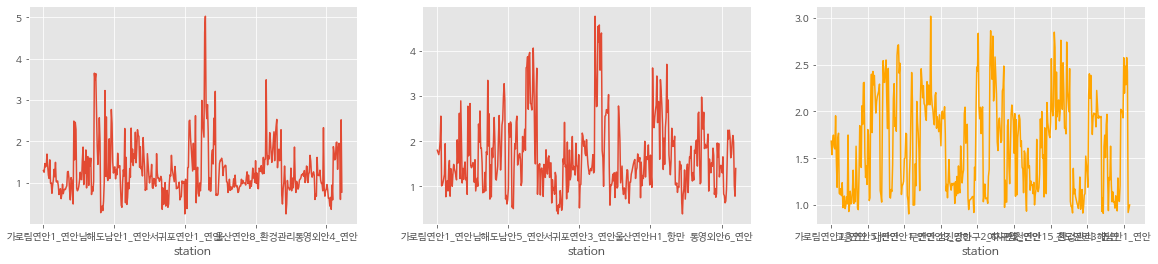

In [ ]:
#좌 2019, 2020 2월 실제 COD 농도 / 우 2021 2월 예측 COD 농도 
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,4)
df.groupby(['year', 'month', 'station']).mean().loc[2019, 2]['COD'].plot(ax=ax1)
df.groupby(['year', 'month', 'station']).mean().loc[2020, 2]['COD'].plot(ax=ax2)
predict28.groupby(['year', 'month', 'station']).mean().loc[2020, 2]['yhat'].plot(ax=ax3, color = 'orange')

In [ ]:
len(nt)

409

In [ ]:
df28.groupby('station').mean().iloc[:,0:2]

,Longitude [degrees_east],Latitude [degrees_north]
station,,
가로림연안1_연안,126.326944,36.946389
가로림연안2_연안,126.313333,36.990000
가로림연안3_연안,126.200000,36.941667
가로림연안4_연안,126.333611,36.922500
가로림연안5_연안,126.322500,36.970833
...,...,...
행암만3_환경관리,128.679720,35.144440
행암만4_환경관리,128.687780,35.146110
후포연안1_연안,129.458889,36.647500


In [ ]:
#이너조인으로 위치 정보만 담긴 데이터프레임에 증감비율 삽입
ud28 = pd.merge(df28.groupby('station').mean().iloc[:,0:2], nt, left_on='station', right_on='station', how='inner')
ud28 = ud28.sort_values(by=['20-21증감비율'], ascending=False).head(10)

In [ ]:
ud28

,Longitude [degrees_east],Latitude [degrees_north],20-21증감비율
station,,,
군산연안5_연안,126.561111,36.016667,237.991953
군산연안3_연안,126.600000,35.979167,224.292440
목포연안5_연안,126.437778,34.787778,188.409366
부산연안3_환경관리,129.126390,35.146110,187.051277
목포연안1_연안,126.425000,34.780278,169.381439
부산연안8_환경관리,129.076390,35.098890,163.784609
광양만9_환경관리,127.723890,34.902500,153.410469
목포연안H1_항만,126.388611,34.785278,148.850743
부산연안1_환경관리,129.169440,35.147220,141.337576


In [ ]:
#Qgis를 위한 export
ud28.to_csv('/content/gdrive/MyDrive/해양/ud28.csv')

In [ ]:
# COD 20-21증감비율 TOP 10 뽑기

m = folium.Map(location=[36.377247, 128.067197], zoom_start=7, prefer_canvas=True)

for i in ud28[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    #if '1' in i:
      #if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
    folium.Circle(location=ud28[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                radius=float(ud28['20-21증감비율'].loc[i])*100, 
                color='red', fill_color='red', fill_opacity=0.2, line_opcity=0.2, 
                tooltip= (i , int(ud28['20-21증감비율'].loc[i])) ).add_to(m)


m

### 외 모델들과 LSTM은 성능이 안좋음, 비교 분석용

### 외 모델들

In [ ]:
def evaluate(pred):

    MAE = mean_absolute_error(y_test, pred)
    MSE = mean_squared_error(y_test, pred)

    def smape(true, pred):
        v = 2 * abs(pred - true) / (abs(pred) + abs(true))
        output = np.mean(v) * 100
        return output

    SMAPE = smape(y_test, pred)
    
    print('MAE : ', MAE)
    print('MSE : ', MSE)
    print('SMAPE : ', SMAPE)

In [ ]:
def visual(model):
  plt.figure(dpi=200)
  #plt.title('COD 예측결과  MAE : ' + str(MAE)[:7])
  plt.ylabel('COD 농도')
  plt.plot(np.array(y), alpha = 0.4, label = 'Real')
  plt.plot(model.predict(X), alpha = 0.4, label = 'Predict')
  plt.legend()
  plt.show()

#### 선형회귀
y라는 종속변수와 한 개 이상의 설명 변수(=독립변수) x들과의 선형 상관관계를 모델링하는 회귀 분석 모델

In [ ]:
# 회귀분석
#선형 회귀는 훈련 데이터에 가장 잘 들어 맞는 선형 방정식 를 찾는 문제입니다. 

model_lr = LinearRegression() 

model_lr.fit(X_train, y_train)
lr_predictions=model_lr.predict(X_test)
train_lr=model_lr.predict(X_train)

In [ ]:
evaluate(lr_predictions)

MAE :  0.4758996136929044
MSE :  0.43180559019713705
SMAPE :  28.486966424395753


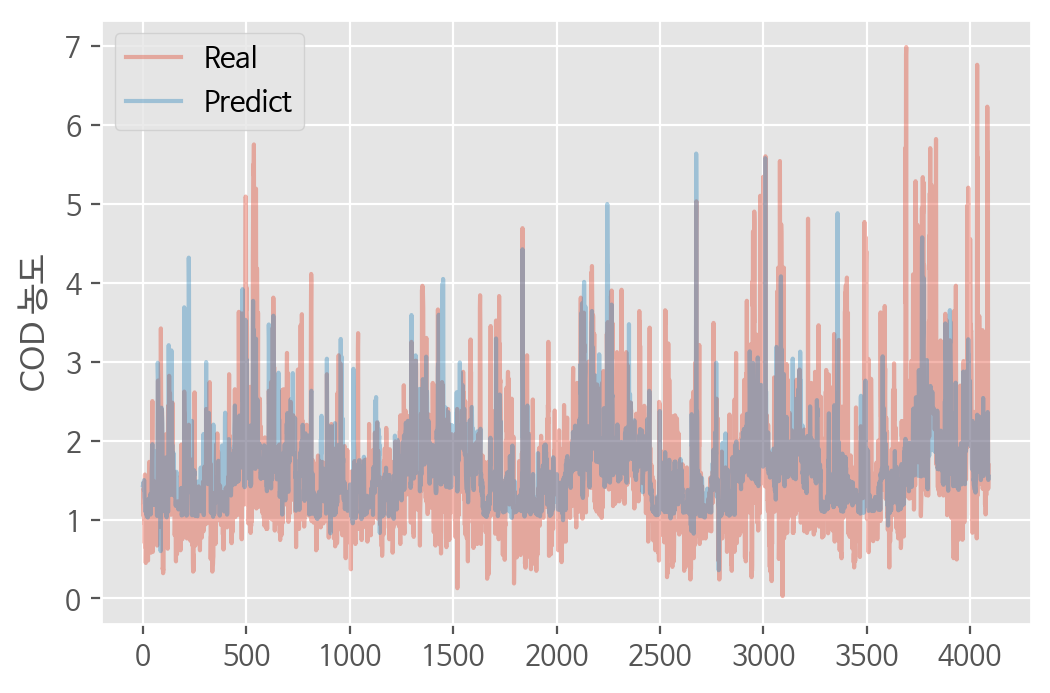

In [ ]:
visual(model_lr)

#### GBoost

앙상블 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하지만 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습시킨다.

In [ ]:
# GBoost

model_GBoost = GradientBoostingRegressor()

model_GBoost.fit(X_train, y_train)
GBoost_predictions=model_GBoost.predict(X_test)
train_GBoost=model_GBoost.predict(X_train)

evaluate(GBoost_predictions)

MAE :  0.42407977638537614
MSE :  0.32625521355777837
SMAPE :  26.175238895852644


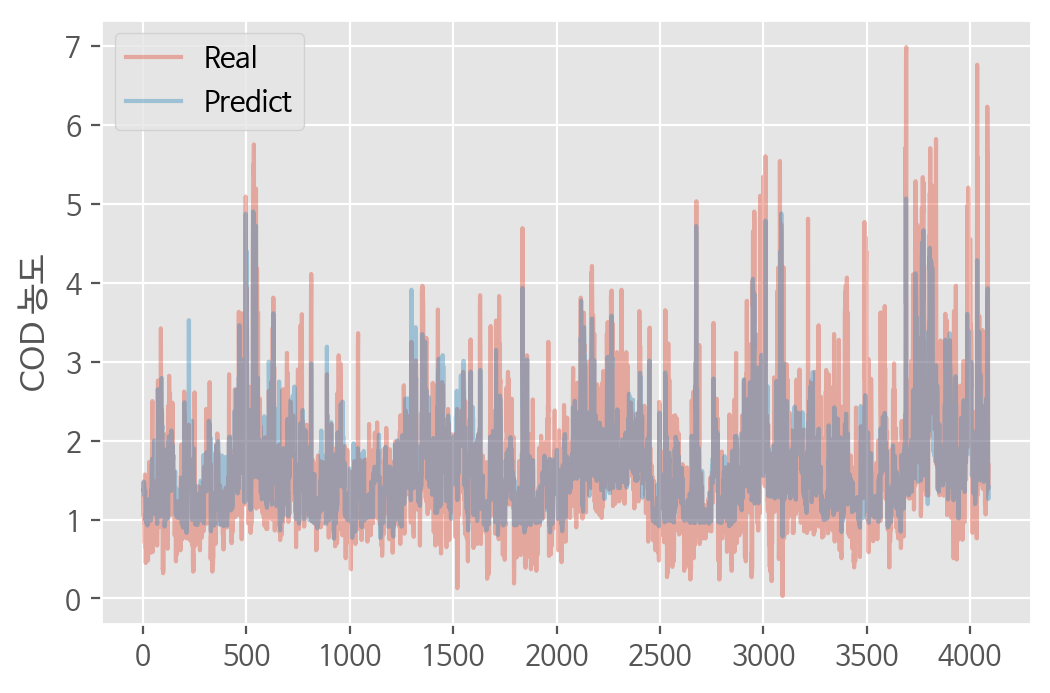

In [ ]:
visual(model_GBoost)

#### Lasso

Ridge, Lasso, elasticNet 회귀 분석에서는 multicollinearity 다중공선성 문제와 over-fitting 과적합 문제 방지를 위해 아래와 같은 정규화 방식이 적용되었습니다.

Ridge 회귀 모델은  L2 정규화

Lasso 회귀모델은 L1 정규화

elasticNet은 Ridge의 L2와 Lasso의 L1 정규화 혼합

Ridge와 수식은 비슷하지만 한 가지 차이점은, 페널티의 계산이 Lambda * coefficient 제곱합이 아니라 Lambda * coefficient 절대값의 합이라는 것입니다. 이 계산은 L1 정규화 방식이고, zero coefficient 를 만드는 것이 가능해집니다. 즉, 어떤 독립변수의 경우 아예 사라지게 될 수도 있게 되면서 feature selection, 상대적으로 더 중요한 독립변수를 선택할 수 있게 됩니다.

MSE가 최소가 되게 하는 가중치와 편향을 찾는데 동시에 가중치들의 절대값들의 합, 즉 가중치의 절대값들이 최소(기울기가 작아지도록)가 되게 해야한다는 것이다. 다시 말해서 가중치의 모든 원소가 0이 되거나 0에 가깝게 되게 해야한다. 따라서 어떤 특성들은 모델을 만들때 사용되지 않는다. 어떤 벡터의 요소들의 절대값들의 합은 L1-norm이므로 라쏘는 간단히 말해서 L1-norm 패널티를 가진 선형 회귀 방법

In [ ]:
# Lasso
#변수의 개수를 줄일 수 없는 Ridge 와 달리 Lasso는 변수의 개수를 줄이고, 모델의 복잡성을 줄여서 모델 성능을 개선시킬 수 있다. 변수가 많은데 그중 일부분만 중요할때 용이함
model_Lasso= Lasso(alpha= 0.000001)
#알파가 작을 수록 복잡도 높아지고 피쳐 많이 사용함
model_Lasso.fit(X_train, y_train)
Lasso_predictions=model_Lasso.predict(X_test)
train_Lasso=model_Lasso.predict(X_train)

evaluate(Lasso_predictions)

MAE :  0.475898464996387
MSE :  0.43180251595624053
SMAPE :  28.486939095332144


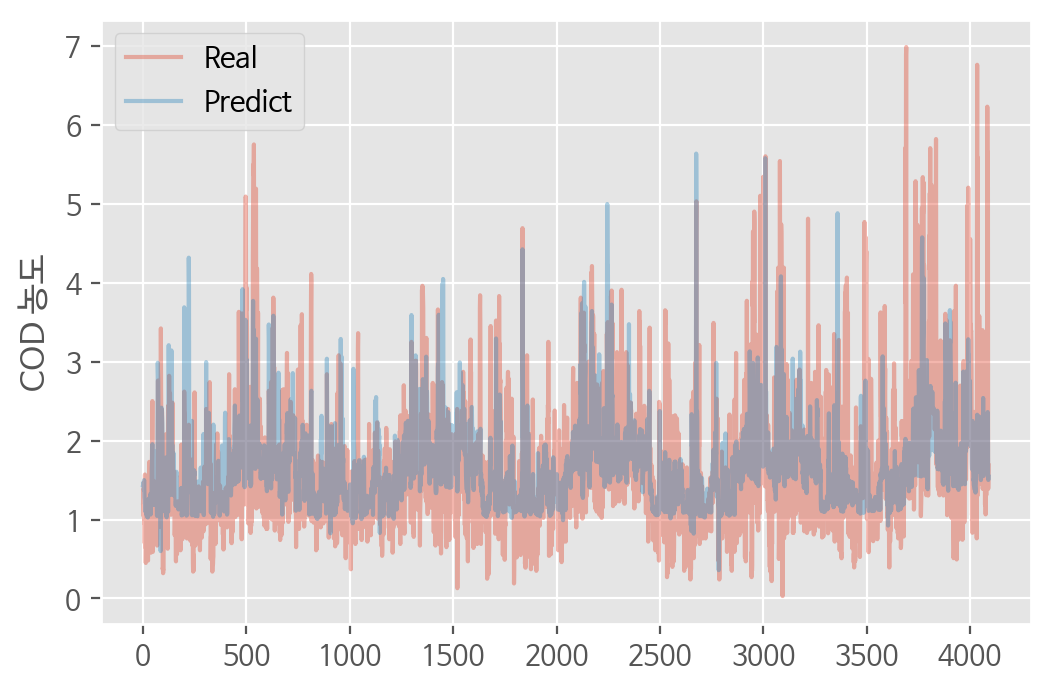

In [ ]:
visual(model_Lasso)

#### elasticNet

alpha가 0에 가까우면 elasticNet은 Ridge에 가까워지고, alpha가 1에 가까우면 elasticNet은 Lasso에 가까워지게 됩니다. elasticNet을 사용하게 되면 Ridge처럼 coefficient의 크기를 줄이면서 Lasso처럼 특정 coefficient를 0으로 만들어 버리면서 특정 독립변수를 사라지게 하는 feature selection 효과를 누릴 수 있게 됩니다.

In [ ]:
# ENet

model_ENet = ElasticNet(alpha=0.001)

model_ENet.fit(X_train, y_train)
ENet_predictions=model_ENet.predict(X_test)
train_ENet=model_ENet.predict(X_train)

evaluate(ENet_predictions)

MAE :  0.4789288490666773
MSE :  0.43347340849349275
SMAPE :  28.742228557893228


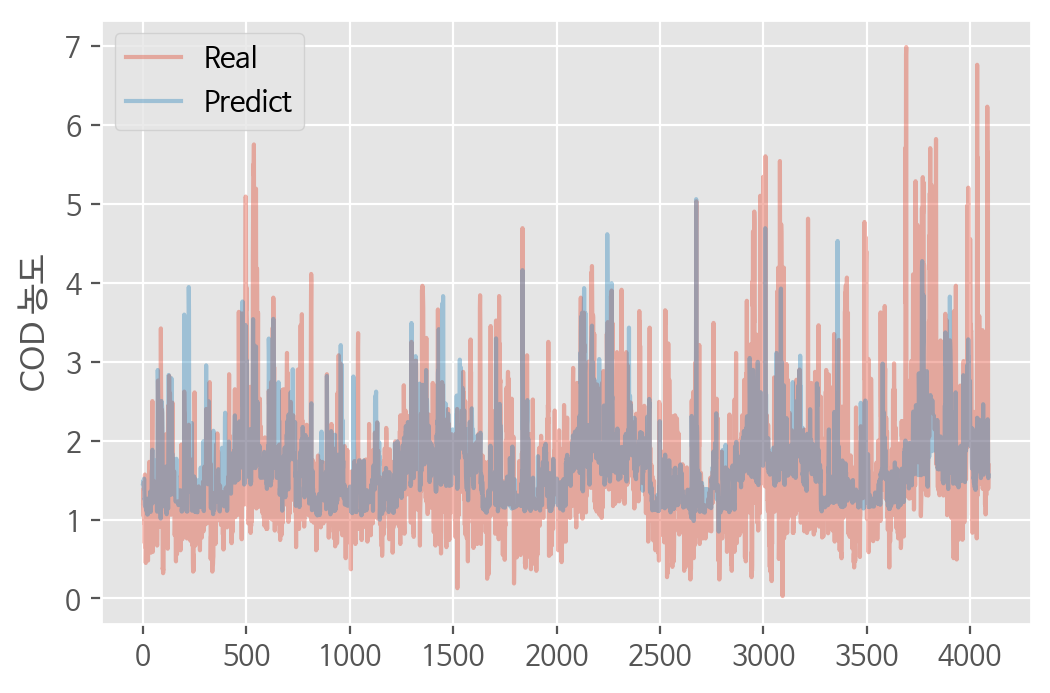

In [ ]:
visual(model_ENet)

#### Ridge
 Linear Regression 선형 회귀모델의 Cost Function 비용함수에 페널티를 적용

 Lambda 값이 0에 가까워지면 Ridge는 본래 Linear Regression의 Cost Function에 가까워지게 됩니다.

 반면에 Lambda의 값이 어느 정도 크다면, coefficient의 크기가 줄어서(0에 가까워져서) 모델의 복잡도가 줄어들고 multicollinearity 문제의 영향을 줄어들게 할 수 있게 됩니다. 왜냐면 서로 영향을 미치는 독립변수들의 weight가 줄어드는 것이기 때문

In [ ]:
# Ridge

model_ridge = Ridge()

model_ridge.fit(X_train, y_train)
ridge_predictions=model_ridge.predict(X_test)
train_ridge=model_ridge.predict(X_train)

evaluate(ridge_predictions)

MAE :  0.4771013085915438
MSE :  0.4319399310850336
SMAPE :  28.583710225959486


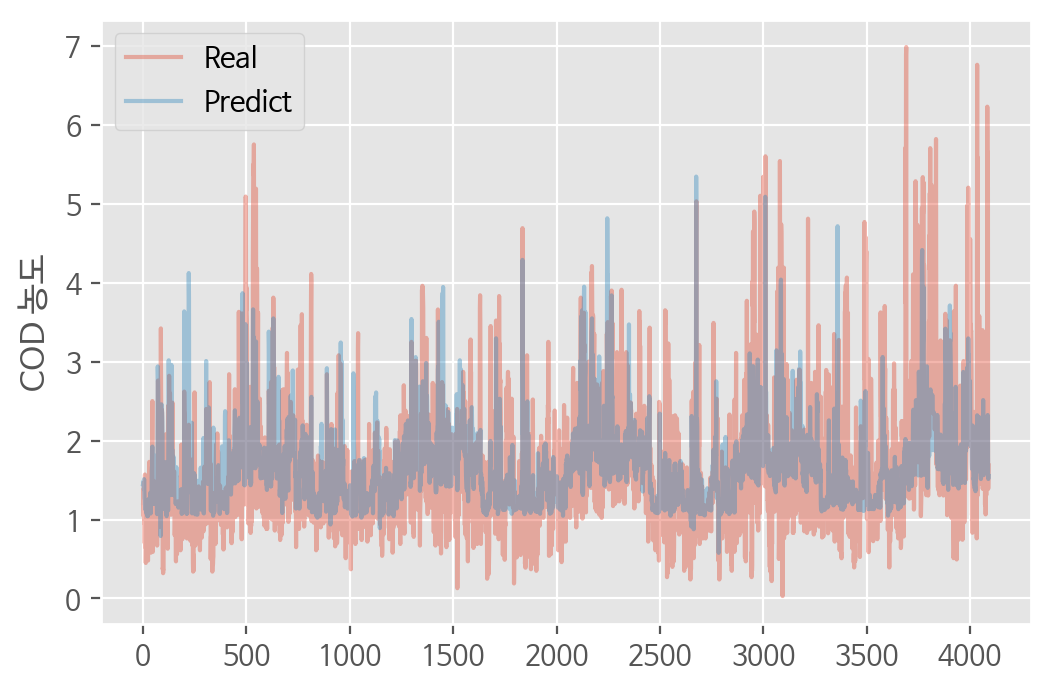

In [ ]:
visual(model_ridge)

#### XGBoost (런타임 너무 오래걸림 사용X)

In [ ]:
X_train

염분[psu]     수온[℃] 클로로필-a[μg/L] 부유물질 농도[mg/L]  \
year month station                                                      
2015 8     낙동강하구5_하구역   0.900500  0.753915     0.218131      0.000011   
2016 8     천수만4_연안      0.900202  0.916232     0.032196      0.047413   
2019 2     광양만6_환경관리    0.927972  0.328628     0.019949      0.026540   
2016 8     고흥연안7_연안     0.936940  0.917153     0.002542      0.015154   
2017 8     부산연안10_환경관리  0.909748  0.861614     0.044058      0.032707   
...                          ...       ...          ...           ...   
     2     부산연안4_환경관리   0.988719  0.419761     0.000231      0.038400   
     8     전주포연안8_연안    0.879664  0.815281     0.085650      0.019898   
     2     마산만3_환경관리    0.929129  0.210801     0.030039      0.031758   
2018 8     통영외안6_연안     0.945618  0.841976     0.015097      0.037451   
2016 8     군산연안7_연안     0.901070  0.890764     0.058230      0.031758   

                       규산염[μg/L] 아질산성질소[μg/L] 질산성질소[μg/L] 암모니아성 질소[μg/L]  \
year month station                                                         
2015 8     낙동강하구5_하구역   0.323734     0.362697    0.457807       0.012470   
2016 8     천수만4_연안      0.133962     0.016490    0.003304       0.030878   
2019 2     광양만6_환경관리    0.011047     0.010012    0.009960       0.004759   
2016 8     고흥연안7_연안     0.007165     0.004711    0.001915       0.005030   
2017 8     부산연안10_환경관리  0.007787     0.007656    0.001772       0.002360   
...                          ...          ...         ...            ...   
     2     부산연안4_환경관리   0.097100     0.045936    0.038641       0.003018   
     8     전주포연안8_연안    0.171803     0.087750    0.008140       0.000929   
     2     마산만3_환경관리    0.064563     0.009423    0.010774       0.011415   
2018 8     통영외안6_연안     0.020618     0.002356    0.001484       0.002825   
2016 8     군산연안7_연안     0.146201     0.019435    0.004022       0.015439   

                        총인[μg/L]  
year month station                
2015 8     낙동강하구5_하구역   0.168691  
2016 8     천수만4_연안      0.172429  
2019 2     광양만6_환경관리    0.066521  
2016 8     고흥연안7_연안     0.046827  
2017 8     부산연안10_환경관리  0.115974  
...                          ...  
     2     부산연안4_환경관리   0.054267  
     8     전주포연안8_연안    0.109847  
     2     마산만3_환경관리    0.080088  
2018 8     통영외안6_연안     0.036761  
2016 8     군산연안7_연안     0.144858  

[3272 rows x 9 columns]

In [ ]:
X_train.columns = ['염분', '수온', '클로로필', '부유물질농도','규산염','아질산성질소','질산성질소','암모니아성질소','총인']

In [ ]:
X_test.columns = ['염분', '수온', '클로로필', '부유물질농도','규산염','아질산성질소','질산성질소','암모니아성질소','총인']

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

model_xgb = xgb.XGBClassifier(learning_rate=0.6,max_depth=5,n_estimators=100, lambda = 0.01 ) 

model_xgb.fit(X_train, y_train)
xgb_predictions=model_xgb.predict(X_test)
#train_xgb=model_xgb.predict(X_train)

In [ ]:
evaluate(xgb_predictions)

MAE :  0.5141192542787286
MSE :  0.5469927740803618
MAPE :  32.94471004696287


In [ ]:
X.columns = ['염분', '수온', '클로로필', '부유물질농도','규산염','아질산성질소','질산성질소','암모니아성질소','총인']

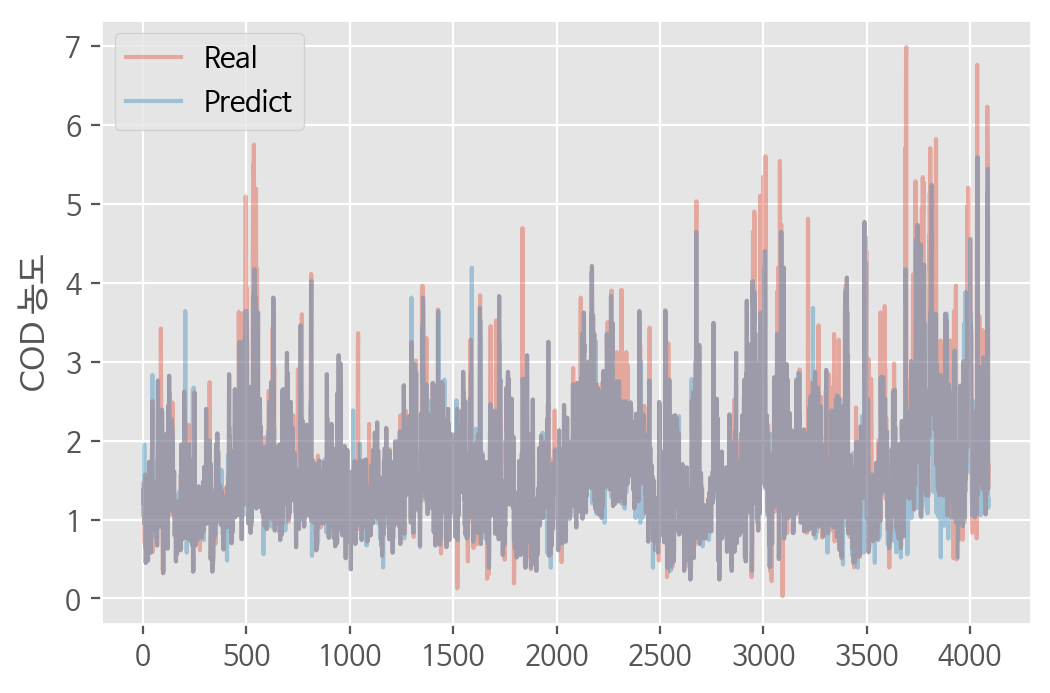

In [ ]:
plt.figure(dpi=200)
plt.ylabel('COD 농도')
plt.plot(np.array(y), alpha = 0.4, label = 'Real')
plt.plot(model_xgb.predict(X), alpha = 0.4, label = 'Predict')
plt.legend()
plt.show()

### 딥러닝 LSTM

In [ ]:
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as pltfrom 
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from tensorflow.keras.models import load_model
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#2월 -> 8월 12개월씩 shift된 yhat
sm28['yhat'] = sm28['COD'].shift(-818)

In [ ]:
#sm28 = sm28.groupby(['station', 'year', 'month']).mean()
sm28 = sm28.groupby(['year', 'month','station']).mean()
sm28

염분[psu]    수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  \
year month station                                                    
2015 2     가로림연안1_연안  32.0841   3.5593         1.092          16.20   
           가로림연안2_연안  32.0735   3.7966         0.996          17.40   
           가로림연안3_연안  32.0572   3.8867         1.088          20.80   
           가로림연안4_연안  32.0980   3.4265         1.020          15.20   
           가로림연안5_연안  32.0889   3.6491         0.924          10.60   
...                       ...      ...           ...            ...   
2020 8     행암만3_환경관리  20.4961  27.4106        23.200           9.10   
           행암만4_환경관리  24.7374  23.5298        34.920           9.10   
           후포연안1_연안   32.1025  22.0892         0.810           6.45   
           후포연안2_연안   32.3917  21.1699         0.940          11.30   
           후포연안H1_항만  31.8048  21.0931         1.752           5.55   

                      규산염[μg/L]  아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  \
year month station                                                           
2015 2     가로림연안1_연안    375.600         1.792      190.232           1.988   
           가로림연안2_연안    384.500         1.834      197.204           2.254   
           가로림연안3_연안    383.900         1.708      197.330           2.828   
           가로림연안4_연안    368.700         1.890      168.588           2.422   
           가로림연안5_연안    374.100         1.386      174.818           1.960   
...                         ...           ...          ...             ...   
2020 8     행암만3_환경관리    792.904        26.334      267.022          67.592   
           행암만4_환경관리    789.432        14.154      118.062          87.948   
           후포연안1_연안      82.712         0.140        1.694           3.276   
           후포연안2_연안      81.536         0.210        4.046           6.104   
           후포연안H1_항만     94.164         0.084        2.338          20.874   

                      총인[μg/L]      COD  yhat  
year month station                             
2015 2     가로림연안1_연안   41.7409  1.49709  1.21  
           가로림연안2_연안   42.4892  1.31546  1.38  
           가로림연안3_연안   43.9692  1.49709  1.23  
           가로림연안4_연안   40.5083  1.43104  1.04  
           가로림연안5_연안   36.3168  1.24941  1.47  
...                        ...      ...   ...  
2020 8     행암만3_환경관리   65.9370  5.65278   NaN  
           행암만4_환경관리   78.0270  5.44040   NaN  
           후포연안1_연안     8.8970  1.38667   NaN  
           후포연안2_연안     9.1140  1.40331   NaN  
           후포연안H1_항만   14.0740  1.68619   NaN  

[4908 rows x 11 columns]

In [ ]:
#학습시킬 테이블과 예측시킬 테이블 나누기 (lstm이라 기존 y(COD) 유지)
learn28 = sm28[sm28['yhat'].notnull()]

predict28 = sm28[sm28['yhat'].isnull()]

learn28.head()

염분[psu]   수온[℃]  클로로필-a[μg/L]  부유물질 농도[mg/L]  규산염[μg/L]  \
year month station                                                              
2015 2     가로림연안1_연안  32.0841  3.5593         1.092           16.2      375.6   
           가로림연안2_연안  32.0735  3.7966         0.996           17.4      384.5   
           가로림연안3_연안  32.0572  3.8867         1.088           20.8      383.9   
           가로림연안4_연안  32.0980  3.4265         1.020           15.2      368.7   
           가로림연안5_연안  32.0889  3.6491         0.924           10.6      374.1   

                      아질산성질소[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                          
2015 2     가로림연안1_연안         1.792      190.232           1.988   41.7409   
           가로림연안2_연안         1.834      197.204           2.254   42.4892   
           가로림연안3_연안         1.708      197.330           2.828   43.9692   
           가로림연안4_연안         1.890      168.588           2.422   40.5083   
           가로림연안5_연안         1.386      174.818           1.960   36.3168   

                          COD  yhat  
year month station                   
2015 2     가로림연안1_연안  1.49709  1.21  
           가로림연안2_연안  1.31546  1.38  
           가로림연안3_연안  1.49709  1.23  
           가로림연안4_연안  1.43104  1.04  
           가로림연안5_연안  1.24941  1.47

In [ ]:
# 독립변수와 COD 만 스케일링

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

learn_sc28 = sc.fit_transform(learn28.loc[:, total28])
learn_sc28 = pd.DataFrame(learn_sc28, columns=[total28], index=learn28.loc[:, total28].index)

predict_sc28 = sc.fit_transform(predict28.loc[:, total28])
predict_sc28 = pd.DataFrame(predict_sc28, columns=[total28], index=predict28.loc[:, total28].index)

learn_sc28.head()

염분[psu]     수온[℃] 클로로필-a[μg/L] 부유물질 농도[mg/L] 규산염[μg/L]  \
year month station                                                              
2015 2     가로림연안1_연안  0.925198  0.141433     0.008411      0.076826  0.111175   
           가로림연안2_연안  0.924892  0.148714     0.007672      0.082518  0.113812   
           가로림연안3_연안  0.924420  0.151479     0.008380      0.098648  0.113634   
           가로림연안4_연안  0.925600  0.137358     0.007856      0.072082  0.109130   
           가로림연안5_연안  0.925337  0.144188     0.007117      0.050259  0.110730   

                     아질산성질소[μg/L] 질산성질소[μg/L] 암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                       
2015 2     가로림연안1_연안     0.010554    0.091088       0.000769  0.160354   
           가로림연안2_연안     0.010801    0.094426       0.000872  0.163629   
           가로림연안3_연안     0.010059    0.094487       0.001094  0.170106   
           가로림연안4_연안     0.011131    0.080724       0.000937  0.154960   
           가로림연안5_연안     0.008163    0.083707       0.000758  0.136616   

                           COD  
year month station              
2015 2     가로림연안1_연안  0.189547  
           가로림연안2_연안  0.166080  
           가로림연안3_연안  0.189547  
           가로림연안4_연안  0.181013  
           가로림연안5_연안  0.157547

In [ ]:
X = learn_sc28
y = learn28['yhat']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [ ]:
y_test_1 = y_test

X = X.values.reshape(-1, 1, 10)
X_train = X_train.values.reshape(-1, 1, 10)
X_test  = X_test.values.reshape(-1, 1, 10)
y_train = y_train.values.reshape(-1, 1, 1)
y_test = y_test.values.reshape(-1, 1, 1)
X.shape

(4090, 1, 10)

In [ ]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(16, input_shape=(828, 10), return_sequences=True))
#model.add(Dense(100, input_shape=[14])) # input_shape=(여기,15)
#model.add(Dense(30)) #model.add(Dense(여기))
model.add(layers.Activation('relu'))
model.add(Dense(16))
#model.add(Dropout(0.1))
model.add(layers.Dense(1))
#model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# 3. 실행
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks= mc, validation_split = 0.1)

loaded_model = load_model('best_model.h5')

Epoch 1/100
92/92 [==============================] - 7s 9ms/step - loss: 1.9138 - val_loss: 0.4976

Epoch 00001: val_loss improved from inf to 0.49758, saving model to best_model.h5
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 0.5923 - val_loss: 0.4601

Epoch 00002: val_loss improved from 0.49758 to 0.46005, saving model to best_model.h5
Epoch 3/100
92/92 [==============================] - 0s 5ms/step - loss: 0.5583 - val_loss: 0.4335

Epoch 00003: val_loss improved from 0.46005 to 0.43347, saving model to best_model.h5
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 0.5315 - val_loss: 0.4128

Epoch 00004: val_loss improved from 0.43347 to 0.41282, saving model to best_model.h5
Epoch 5/100
92/92 [==============================] - 0s 4ms/step - loss: 0.5110 - val_loss: 0.3992

Epoch 00005: val_loss improved from 0.41282 to 0.39920, saving model to best_model.h5
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 0

(0.2, 0.5)

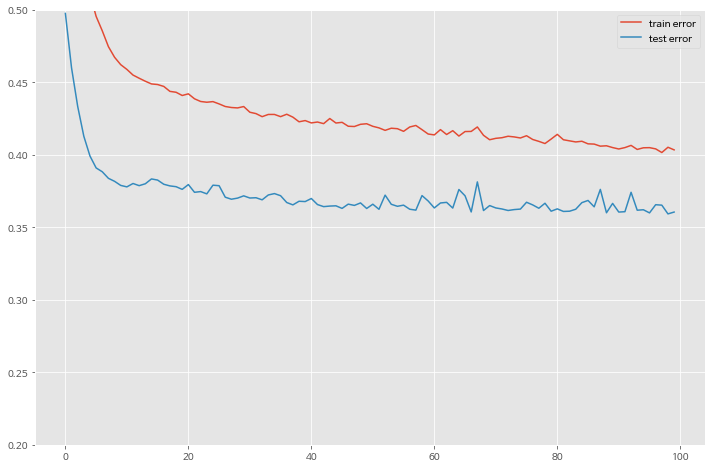

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='test error')
plt.legend()
plt.ylim([0.2,0.5])

In [ ]:
y_pred = loaded_model.predict(X_test)
R2 = r2_score(y_test_1, y_pred.reshape(-1,1))
MAE = mean_absolute_error(y_test_1, y_pred.reshape(-1,1))

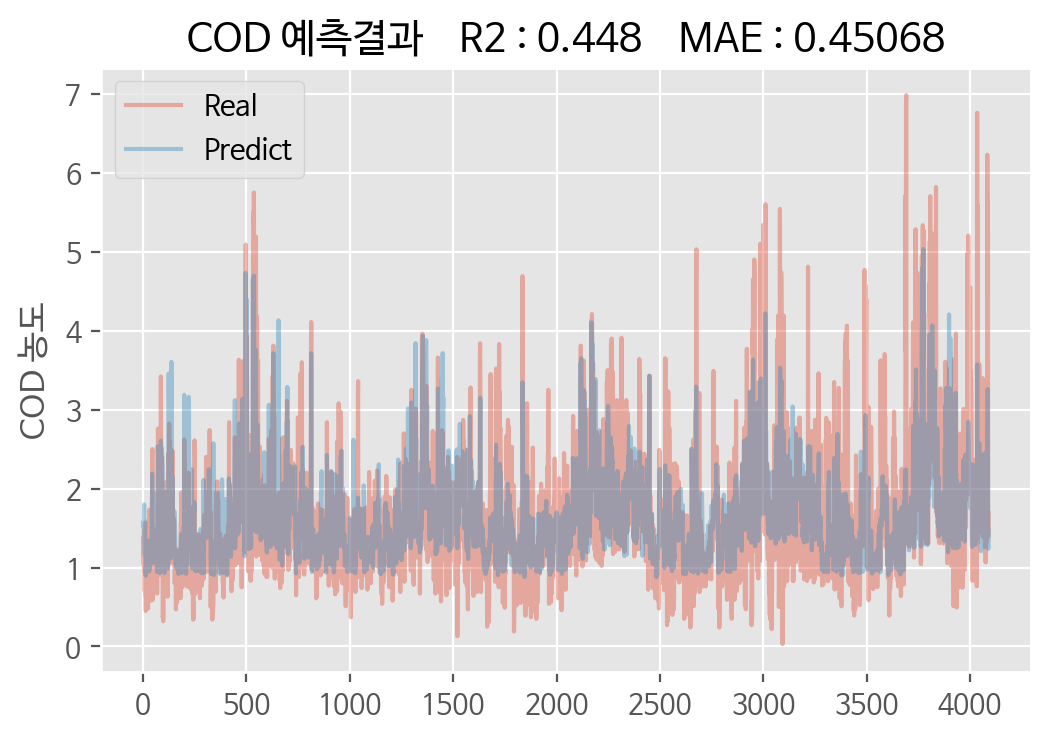

In [ ]:
plt.figure(dpi=200)
plt.title('COD 예측결과    R2 : ' + str(R2)[:5] + '    MAE : ' + str(MAE)[:7])
plt.ylabel('COD 농도')
plt.plot(np.array(y), alpha = 0.4, label = 'Real')
plt.plot(loaded_model.predict(X).reshape(-1,1), alpha = 0.4, label = 'Predict')
plt.legend()
plt.show()

## 5월 11월 봄 가을 데이터 분석

In [ ]:
df511

,station,date,Longitude [degrees_east],Latitude [degrees_north],총질소[μg/L],염분[psu],수온[℃],클로로필-a[μg/L],부유물질 농도[mg/L],용존산소[mg/L],수소이온농도[무단위],규산염[μg/L],아질산성질소[μg/L],인산염인[μg/L],질산성질소[μg/L],용존무기질소[μg/L],암모니아성 질소[μg/L],총인[μg/L],COD,year,month,day,hour
2,가로림연안1_연안,2015-05-10 00:00:00,126.326944,36.946389,407.890,31.9136,9.7594,3.220,13.60,10.34200,8.16,88.452,2.254,12.834,131.614,136.150,2.282,23.0668,1.044110,2015,5,10,0
10,가로림연안2_연안,2015-05-10 00:00:00,126.313333,36.990000,406.463,31.9373,9.4244,3.292,13.40,10.32500,8.15,89.600,2.604,13.299,134.848,140.210,2.758,26.5856,1.077610,2015,5,10,0
18,가로림연안3_연안,2015-05-10 00:00:00,126.200000,36.941667,411.598,31.9199,8.8112,3.632,16.20,10.27400,8.14,85.372,2.730,13.423,135.072,144.354,6.552,26.0986,1.010610,2015,5,10,0
26,가로림연안4_연안,2015-05-10 00:00:00,126.333611,36.922500,306.783,31.9240,10.1046,3.432,16.00,10.08720,8.14,96.404,2.618,12.865,125.174,130.200,2.408,26.7245,1.168350,2015,5,10,0
34,가로림연안5_연안,2015-05-10 00:00:00,126.322500,36.970833,315.707,31.9104,9.3527,3.976,22.00,10.27400,8.16,84.700,2.632,13.392,133.518,138.320,2.170,31.7549,1.111110,2015,5,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,행암만2_환경관리,2020-11-02 15:25:00,128.680560,35.138890,294.378,31.6811,18.3275,15.160,5.40,7.96772,8.11,390.488,26.096,13.330,71.512,130.256,32.648,39.5870,1.891490,2020,11,2,15
3132,행암만3_환경관리,2020-11-02 15:18:00,128.679720,35.144440,377.370,31.6780,18.3762,15.680,8.50,7.68677,8.08,449.932,26.320,17.112,78.736,178.332,73.276,53.1650,2.428040,2020,11,2,15
3140,행암만4_환경관리,2020-11-02 15:10:00,128.687780,35.146110,354.928,31.6258,18.4858,19.840,10.60,7.68620,8.07,411.964,26.894,13.671,74.424,164.738,63.420,51.8010,2.541850,2020,11,2,15
3148,후포연안1_연안,2020-11-01 12:14:00,129.458889,36.647500,148.526,33.6932,15.8416,1.086,2.55,8.01103,8.22,144.984,3.220,6.386,36.428,43.484,3.836,16.8020,1.040730,2020,11,1,12


### Feature 선별

#### Feature들간 상관관계

In [ ]:
df_corr511 = df511.drop(columns=['station', 'date', 'Longitude [degrees_east]','Latitude [degrees_north]','year', 'month', 'day', 'hour'],axis=1)
scaler= MinMaxScaler()
df_corr511[df_corr511.columns] = scaler.fit_transform(df_corr511[df_corr511.columns])
corr511 = df_corr511.corr(method= 'pearson')

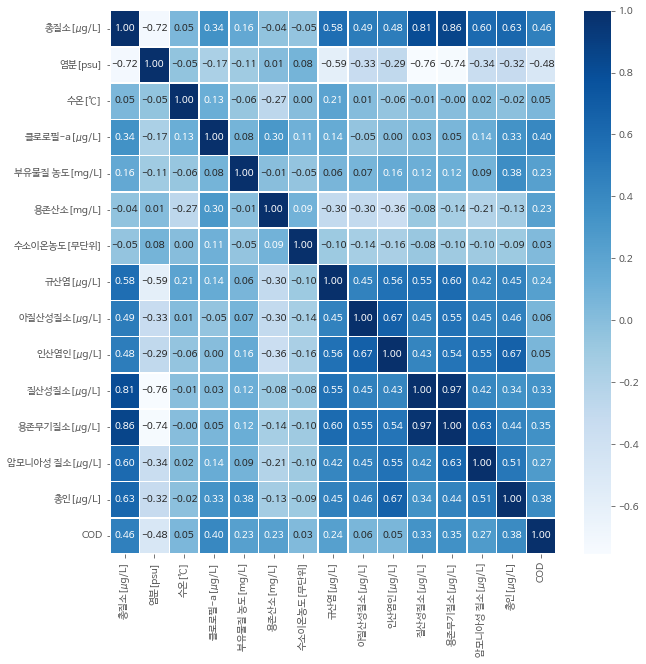

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns    
plt.figure(figsize=(10,10))
sns.heatmap(data = corr511, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

# 변수들간 상관관계가 높은 총질소와 용존무기질소 모델링에서 제외

#### COD와 Feature 상관관계

In [ ]:
df_corr511 = df511.drop(columns=['총질소[μg/L]', '용존무기질소[μg/L]', 'station', 'date', 'Longitude [degrees_east]','Latitude [degrees_north]','year', 'month', 'day', 'hour'],axis=1)
scaler= MinMaxScaler()
df_corr511[df_corr511.columns] = scaler.fit_transform(df_corr511[df_corr511.columns])
corr511 = df_corr511.corr(method= 'pearson')

In [ ]:
s511 = corr511.unstack()
df_temp511 = pd.DataFrame(s511['COD'].sort_values(ascending=False), columns=['COD'])
df_temp511.style.background_gradient(cmap='viridis')

#0.1미만인 아질산성질소, 인산염인, 수온, 수소이온농도 모델링에서 제외

,COD
COD,1.000000
클로로필-a[μg/L],0.404387
총인[μg/L],0.383585
질산성질소[μg/L],0.330229
암모니아성 질소[μg/L],0.268703
규산염[μg/L],0.237258
용존산소[mg/L],0.226695
부유물질 농도[mg/L],0.225079
아질산성질소[μg/L],0.055445
인산염인[μg/L],0.054412


In [ ]:
df511 = df511.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '아질산성질소[μg/L]', '인산염인[μg/L]', '수온[℃]', '수소이온농도[무단위]'], axis = 1)

#### 시각화

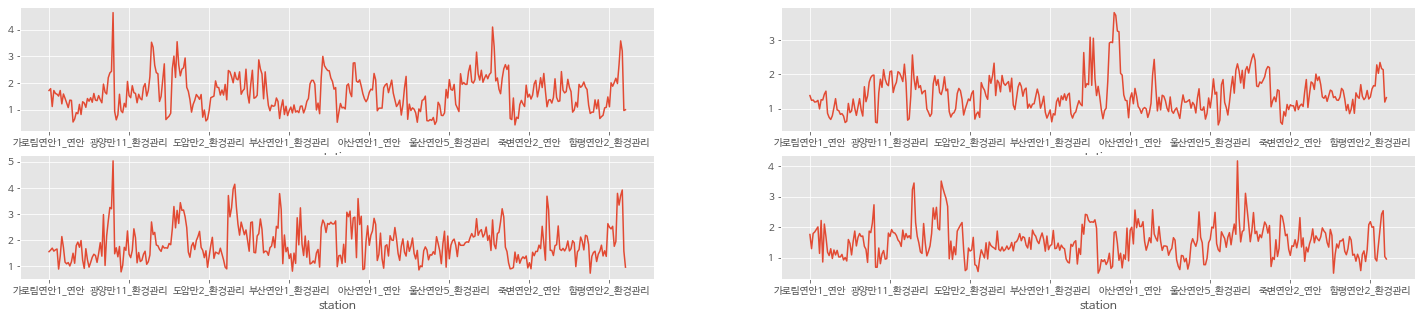

In [ ]:
# 그래프 시각화

#19/20년도 5/11월 COD 농도 station 별로 보기
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(25,5)
df511.groupby(['year', 'month', 'station']).mean().loc[2019, 5]['COD'].plot(ax=ax1)
df511.groupby(['year', 'month', 'station']).mean().loc[2019, 11]['COD'].plot(ax=ax2)
df511.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['COD'].plot(ax=ax3)
df511.groupby(['year', 'month', 'station']).mean().loc[2020, 11]['COD'].plot(ax=ax4)

In [ ]:
# COD와 총인 지도 시각화 (연안1)

m = folium.Map(location=[36.377247, 128.067197], zoom_start=7, prefer_canvas=True)

for i in df511.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    if '1' in i:
      if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
        folium.Circle(location=df511.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                    radius=float(df511.groupby('station').mean()['COD'].loc[i])*5000, 
                    color='#FF3333', fill_color='#FF3333', fill_opacity=0.2, line_opcity=0.2, 
                    tooltip=int(df511.groupby('station').mean()['COD'].loc[i])).add_to(m)

for i in df511.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    if '1' in i:
      if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
        folium.Circle(location=df511.groupby('station').mean()[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                    radius=float(df511.groupby('station').mean()['총인[μg/L]'].loc[i])*280, 
                    color='#1BA879', fill_color='#1BA879', fill_opacity=0.2, line_opcity=0.2, 
                    tooltip=int(df511.groupby('station').mean()['총인[μg/L]'].loc[i])).add_to(m)


m

### df511 모델링

#### 모델링 데이터프레임 만들기 
sm511 : 년/월/구역 별 테이블

learn511/predict511 : 학습시킬 테이블과 예측시킬 테이블

learn511_sc/predict511_sc : 스케일링된 독립변수 테이블

In [56]:
feature = df.columns[4:19]
total511 = feature.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '아질산성질소[μg/L]', '인산염인[μg/L]', '수온[℃]', '수소이온농도[무단위]'])
ft511 = feature.drop(['총질소[μg/L]', '용존무기질소[μg/L]', '아질산성질소[μg/L]', '인산염인[μg/L]', '수온[℃]', '수소이온농도[무단위]', 'COD'])
target = 'COD'
ft511

Index(['염분[psu]', '클로로필-a[μg/L]', '부유물질 농도[mg/L]', '용존산소[mg/L]', '규산염[μg/L]',
       '질산성질소[μg/L]', '암모니아성 질소[μg/L]', '총인[μg/L]'],
      dtype='object')

In [57]:
len(ft511)

8

In [58]:
sm511 = df511.groupby(['year', 'month', 'station'])[total511].mean()

In [59]:
sm511

염분[psu]  클로로필-a[μg/L]  부유물질 농도[mg/L]  용존산소[mg/L]  \
year month station                                                       
2015 5     가로림연안1_연안  31.9136         3.220          13.60    10.34200   
           가로림연안2_연안  31.9373         3.292          13.40    10.32500   
           가로림연안3_연안  31.9199         3.632          16.20    10.27400   
           가로림연안4_연안  31.9240         3.432          16.00    10.08720   
           가로림연안5_연안  31.9104         3.976          22.00    10.27400   
...                       ...           ...            ...         ...   
2020 11    행암만2_환경관리  31.6811        15.160           5.40     7.96772   
           행암만3_환경관리  31.6780        15.680           8.50     7.68677   
           행암만4_환경관리  31.6258        19.840          10.60     7.68620   
           후포연안1_연안   33.6932         1.086           2.55     8.01103   
           후포연안2_연안   33.6482         2.680           5.10     8.08893   

                      규산염[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                       
2015 5     가로림연안1_연안     88.452      131.614           2.282   23.0668   
           가로림연안2_연안     89.600      134.848           2.758   26.5856   
           가로림연안3_연안     85.372      135.072           6.552   26.0986   
           가로림연안4_연안     96.404      125.174           2.408   26.7245   
           가로림연안5_연안     84.700      133.518           2.170   31.7549   
...                         ...          ...             ...       ...   
2020 11    행암만2_환경관리    390.488       71.512          32.648   39.5870   
           행암만3_환경관리    449.932       78.736          73.276   53.1650   
           행암만4_환경관리    411.964       74.424          63.420   51.8010   
           후포연안1_연안     144.984       36.428           3.836   16.8020   
           후포연안2_연안     132.860       32.060           3.472   17.1120   

                           COD  
year month station              
2015 5     가로림연안1_연안  1.044110  
           가로림연안2_연안  1.077610  
           가로림연안3_연안  1.010610  
           가로림연안4_연안  1.168350  
           가로림연안5_연안  1.111110  
...                        ...  
2020 11    행암만2_환경관리  1.891490  
           행암만3_환경관리  2.428040  
           행암만4_환경관리  2.541850  
           후포연안1_연안   1.040730  
           후포연안2_연안   0.960672  

[4332 rows x 9 columns]

In [60]:
#5월 -> 5월 12개월씩 shift된 yhat
sm511['yhat'] = sm511['COD'].shift(-722)
sm511.head(723)

염분[psu]  클로로필-a[μg/L]  부유물질 농도[mg/L]  용존산소[mg/L]  \
year month station                                                       
2015 5     가로림연안1_연안  31.9136        3.2200          13.60    10.34200   
           가로림연안2_연안  31.9373        3.2920          13.40    10.32500   
           가로림연안3_연안  31.9199        3.6320          16.20    10.27400   
           가로림연안4_연안  31.9240        3.4320          16.00    10.08720   
           가로림연안5_연안  31.9104        3.9760          22.00    10.27400   
...                       ...           ...            ...         ...   
     11    행암만3_환경관리  31.7064        9.6000          10.60     6.40752   
           행암만4_환경관리  31.8004        8.0667           7.00     7.85184   
           후포연안1_연안   33.6634        0.2400           1.00     8.15961   
           후포연안2_연안   33.7370        0.6800           2.13     8.34434   
2016 5     가로림연안1_연안  31.9700        0.9000           8.30     8.84000   

                      규산염[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                       
2015 5     가로림연안1_연안     88.452     131.6140           2.282   23.0668   
           가로림연안2_연안     89.600     134.8480           2.758   26.5856   
           가로림연안3_연안     85.372     135.0720           6.552   26.0986   
           가로림연안4_연안     96.404     125.1740           2.408   26.7245   
           가로림연안5_연안     84.700     133.5180           2.170   31.7549   
...                         ...          ...             ...       ...   
     11    행암만3_환경관리    764.584      73.4440         187.567   76.0934   
           행암만4_환경관리    764.708      98.7607         165.774   71.1977   
           후포연안1_연안     260.596      76.3140           4.746   16.6693   
           후포연안2_연안     263.648      74.1440           4.746   17.0884   
2016 5     가로림연안1_연안    321.000     172.6000           6.300   38.8000   

                           COD  yhat  
year month station                    
2015 5     가로림연안1_연안  1.044110  1.17  
           가로림연안2_연안  1.077610  1.25  
           가로림연안3_연안  1.010610  0.77  
           가로림연안4_연안  1.168350  1.23  
           가로림연안5_연안  1.111110  0.70  
...                        ...   ...  
     11    행암만3_환경관리  1.528150  1.72  
           행암만4_환경관리  1.460480  1.55  
           후포연안1_연안   2.757440  0.93  
           후포연안2_연안   0.862757  1.09  
2016 5     가로림연안1_연안  1.170000  0.95  

[723 rows x 10 columns]

In [61]:
#학습시킬 테이블과 (COD yhat을) 예측시킬 테이블 나누기 (기존 y(COD) 는 삭제)
learn511 = sm511[sm511['yhat'].notnull()]
learn511 = learn511.drop(['COD'], axis=1)

predict511 = sm511[sm511['yhat'].isnull()]
predict511 = predict511.drop(["COD"], axis=1)

learn511.head()

염분[psu]  클로로필-a[μg/L]  부유물질 농도[mg/L]  용존산소[mg/L]  \
year month station                                                       
2015 5     가로림연안1_연안  31.9136         3.220           13.6     10.3420   
           가로림연안2_연안  31.9373         3.292           13.4     10.3250   
           가로림연안3_연안  31.9199         3.632           16.2     10.2740   
           가로림연안4_연안  31.9240         3.432           16.0     10.0872   
           가로림연안5_연안  31.9104         3.976           22.0     10.2740   

                      규산염[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  yhat  
year month station                                                            
2015 5     가로림연안1_연안     88.452      131.614           2.282   23.0668  1.17  
           가로림연안2_연안     89.600      134.848           2.758   26.5856  1.25  
           가로림연안3_연안     85.372      135.072           6.552   26.0986  0.77  
           가로림연안4_연안     96.404      125.174           2.408   26.7245  1.23  
           가로림연안5_연안     84.700      133.518           2.170   31.7549  0.70

In [62]:
# 독립변수만 스케일링

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

learn_sc511 = sc.fit_transform(learn511.loc[:, ft511])
learn_sc511 = pd.DataFrame(learn_sc511, columns=[ft511], index=learn511.loc[:, ft511].index)

predict_sc511 = sc.fit_transform(predict511.loc[:, ft511])
predict_sc511 = pd.DataFrame(predict_sc511, columns=[ft511], index=predict511.loc[:, ft511].index)

learn_sc511.head()

염분[psu] 클로로필-a[μg/L] 부유물질 농도[mg/L] 용존산소[mg/L]  \
year month station                                                     
2015 5     가로림연안1_연안  0.900289     0.024846      0.020172   0.572743   
           가로림연안2_연안  0.901188     0.025401      0.019875   0.571185   
           가로림연안3_연안  0.900528     0.028025      0.024028   0.566513   
           가로림연안4_연안  0.900683     0.026481      0.023732   0.549400   
           가로림연안5_연안  0.900167     0.030679      0.032631   0.566513   

                     규산염[μg/L] 질산성질소[μg/L] 암모니아성 질소[μg/L]  총인[μg/L]  
year month station                                                   
2015 5     가로림연안1_연안  0.024798    0.070767       0.002822  0.055989  
           가로림연안2_연안  0.025121    0.072508       0.003411  0.066523  
           가로림연안3_연안  0.023932    0.072628       0.008103  0.065065  
           가로림연안4_연안  0.027034    0.067302       0.002978  0.066939  
           가로림연안5_연안  0.023743    0.071792       0.002684  0.081998

#### 모델링

In [63]:
import tensorflow as tf
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [70]:
X = learn_sc511
y = learn511['yhat']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 123456)

#### 랜덤포레스트

In [ ]:
# #랜덤 포레스트

# with tf.device('/device:GPU:0'):
#   model = RandomForestRegressor()
#   model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# R2 = r2_score(y_test, y_pred)
# MAE = mean_absolute_error(y_test, y_pred)

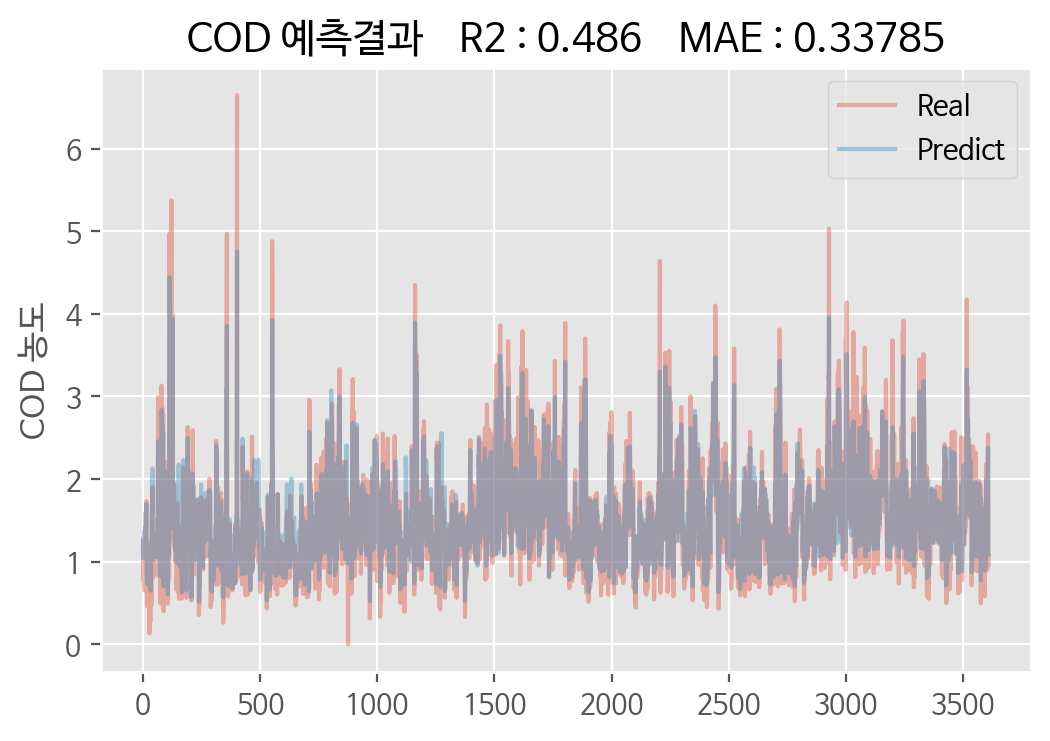

In [ ]:
# plt.figure(dpi=200)
# plt.title('COD 예측결과    R2 : ' + str(R2)[:5] + '    MAE : ' + str(MAE)[:7])
# plt.ylabel('COD 농도')
# plt.plot(np.array(y), alpha = 0.4, label = 'Real')
# plt.plot(model.predict(X), alpha = 0.4, label = 'Predict')
# plt.legend()
# plt.show()

In [ ]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error 
# from sklearn.metrics import mean_squared_log_error
# #MAE를 퍼센트로 변환
# def MAPE(y_test, y_pred):
# 	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
# def MPE(y_test, y_pred): 
# 	return np.mean((y_test - y_pred) / y_test) * 100

# MAE = mean_absolute_error(y_test, y_pred)
# #MAE는 실제 관측값과 회귀식으로 예측한 값 차이를 제곱 합이 아닌 절대값의 합
# MSE = mean_squared_error(y_test, y_pred)
# #MSE는 SSE를 자유도로 나누어준 값이다. 
# #자유도를 나누어 줌으로써 MSE가 크다의 의미는 단순히 데이터가 많아서 크다는 것이 아니라(SSE는 데이터 수가 많아지면 커진다.) 실제 차이가 커서 크다고 판단할 수 있게 되는 것이다.

# RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(y_test, y_pred)    
# MAPE = MAPE(y_test, y_pred)
# #MAPE는 MAE에서 실제 관측값과 회귀식으로 예측한 값 차이를 회귀식으로 예측한 값으로 나눈 절대값의 합이다. 
# #MAE는 outlier에 취약할 수 있는데(한 없이 커질 수 있다는 의미이다.) MAPE는 최대 크기가 제한되므로 이를 보완한 개념
# MPE = MPE(y_test, y_pred)

# print('MAE : ', MAE)
# print('MSE : ', MSE)
# print('RMSE : ', RMSE)
# print('MSLE : ', MSLE)
# print('MAPE : ', MAPE)
# print('MPE : ', MPE)

MAE :  0.33378438938336796
MSE :  0.21229000600183176
RMSE :  0.4607493960949181
MSLE :  0.03117154703352391
MAPE :  inf
MPE :  -inf


#### 하이퍼파리마터 튜닝

In [72]:
#하이퍼 파리미터 튜닝
from sklearn.model_selection import GridSearchCV

params =[
        {'n_estimators': [30, 50, 80], 'max_features': [4,5,6,7]}
    ]

rf_model511 = RandomForestRegressor()
rf_model511 = GridSearchCV(rf_model511, param_grid=params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
rf_model511.fit(X_train,y_train)
rf_model511.best_params_

{'max_features': 7, 'n_estimators': 80}

In [ ]:
cvres = rf_model511.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(round(np.sqrt(-mean_score),3), params)

0.487 {'max_features': 7, 'n_estimators': 80}


In [73]:
y_pred511 = rf_model511.predict(X_test)
R2 = r2_score(y_test, y_pred511)
MAE = mean_absolute_error(y_test, y_pred511)

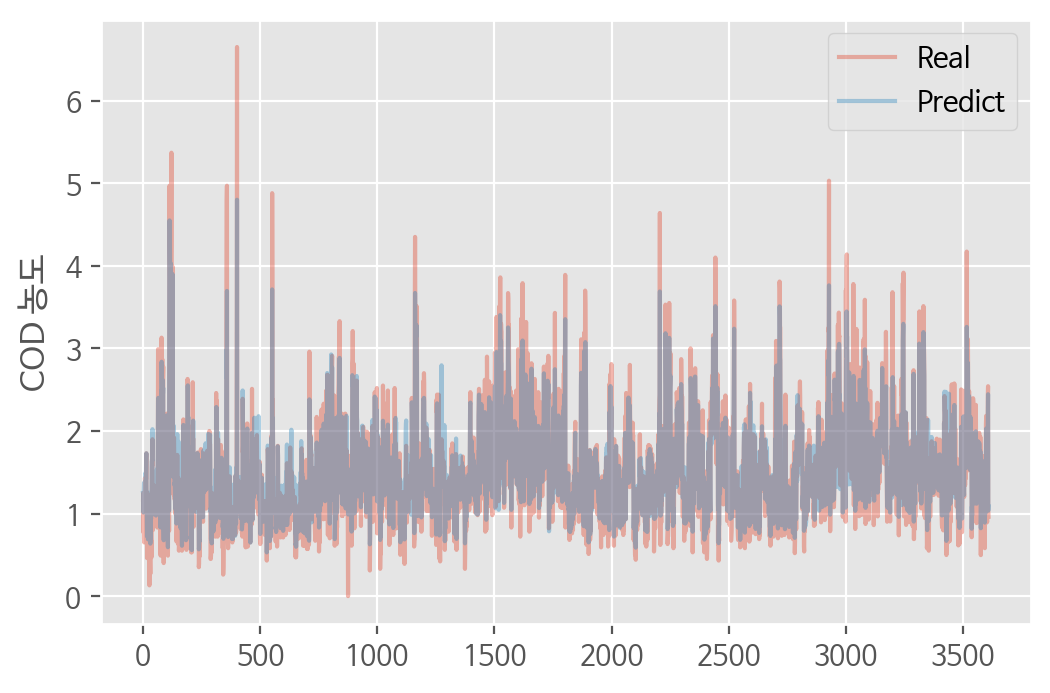

In [75]:
plt.figure(dpi=200)
plt.ylabel('COD 농도')
plt.plot(np.array(y), alpha = 0.4, label = 'Real')
plt.plot(rf_model511.predict(X), alpha = 0.4, label = 'Predict')
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
import os
import glob

MAE = mean_absolute_error(y_test, y_pred511)
#MAE는 실제 관측값과 회귀식으로 예측한 값 차이를 제곱 합이 아닌 절대값의 합

MSE = mean_squared_error(y_test, y_pred511)
#MSE는 SSE를 자유도로 나누어준 값이다. 
#자유도를 나누어 줌으로써 MSE가 크다의 의미는 단순히 데이터가 많아서 크다는 것이 아니라(SSE는 데이터 수가 많아지면 커진다.) 실제 차이가 커서 크다고 판단할 수 있게 되는 것이다.

#MAPE는 MAE에서 실제 관측값과 회귀식으로 예측한 값 차이를 회귀식으로 예측한 값으로 나눈 절대값의 합이다. 
#SMAPE는 0이나 0에 근접한 데이터가 포함되는 경우엔 MAPE는 전체 오류율을 왜곡시키므로 이러한 경우엔 SMAPE가 더 적합한 방법으로 사용된다.
#Symmetric mean absolute percentage error (SMAPE 또는 sMAPE)는 백분율(퍼센티지, 또는 상대) 오류를 기반으로 한 정확도 측정 방법이다. 
#평균 절대 백분율 오차(MAPE, Mean absolute percentage error)와 달리 SMAPE엔 상한과 하한이 있다. 
#SMAPE의 이러한 값의 제한은 MAPE에서 발생하는 오류율의 왜곡을 막아준다. 
#SMAPE에도 한계가 있는데 실제 값 또는 예측 값이 0인 경우 오류 값이 오류의 상한값까지 상승한다는 것이다. 

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

SMAPE = smape(y_test, y_pred511)

print('MAE : ', MAE)
print('MSE : ', MSE)
print('SMAPE : ', SMAPE)

MAE :  0.38240277270236644
MSE :  0.26189622402560997
SMAPE :  23.880445586575913


### 12개월 이후 yhat 예측 (랜포)

In [ ]:
#12개월 후 값 예측하여 값 저장
newpred511 = rf_model511.predict(predict_sc511)

In [ ]:
#기존 yhat이 NaN 행에  예측 값 넣어주기
predict511['yhat'] = newpred
predict511

염분[psu]  클로로필-a[μg/L]  부유물질 농도[mg/L]  용존산소[mg/L]  \
year month station                                                       
2020 5     가로림연안1_연안  31.7727      0.503333        28.2000     9.15351   
           가로림연안2_연안  31.8114      0.555000        22.7000     9.33276   
           가로림연안3_연안  31.7912      2.405000        68.3333     9.26712   
           가로림연안4_연안  31.7583      2.006670        21.4000     8.90711   
           가로림연안5_연안  31.7619      2.550000        63.3000     9.22719   
...                       ...           ...            ...         ...   
     11    행암만2_환경관리  31.6811     15.160000         5.4000     7.96772   
           행암만3_환경관리  31.6780     15.680000         8.5000     7.68677   
           행암만4_환경관리  31.6258     19.840000        10.6000     7.68620   
           후포연안1_연안   33.6932      1.086000         2.5500     8.01103   
           후포연안2_연안   33.6482      2.680000         5.1000     8.08893   

                      규산염[μg/L]  질산성질소[μg/L]  암모니아성 질소[μg/L]  총인[μg/L]  \
year month station                                                       
2020 5     가로림연안1_연안    138.376      137.592           3.080    34.317   
           가로림연안2_연안    131.320      140.140           7.616    29.047   
           가로림연안3_연안    115.612      140.084           1.764    35.836   
           가로림연안4_연안    153.916      132.636           2.772    33.480   
           가로림연안5_연안    127.428      138.922           3.164    34.317   
...                         ...          ...             ...       ...   
     11    행암만2_환경관리    390.488       71.512          32.648    39.587   
           행암만3_환경관리    449.932       78.736          73.276    53.165   
           행암만4_환경관리    411.964       74.424          63.420    51.801   
           후포연안1_연안     144.984       36.428           3.836    16.802   
           후포연안2_연안     132.860       32.060           3.472    17.112   

                          yhat  
year month station              
2020 5     가로림연안1_연안  1.234150  
           가로림연안2_연안  1.502833  
           가로림연안3_연안  1.393120  
           가로림연안4_연안  1.233280  
           가로림연안5_연안  1.500731  
...                        ...  
     11    행암만2_환경관리  2.166365  
           행암만3_환경관리  2.327953  
           행암만4_환경관리  2.260184  
           후포연안1_연안   1.561973  
           후포연안2_연안   1.376854  

[722 rows x 9 columns]

#### yhat 증감비율

In [ ]:
#2020년 5월
twenty2 = df511.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['COD']
#2021년 5월
twentyone2 = predict511.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['yhat']

In [ ]:
nt2 = pd.concat([twenty2,twentyone2], axis=1)
nt2 = nt2.T.pct_change()*100
nt2 = nt2.drop(index='COD', axis=0)
nt2 = nt2.rename(index={'yhat': '20-21증감비율'})
nt2 = nt2.T.sort_values(by=['20-21증감비율'], ascending=False)
nt2.head(10)

,20-21증감비율
station,
부산연안3_환경관리,212.523324
가막만1_환경관리,190.611237
고흥연안5_연안,185.600854
여수연안1_연안,181.116504
죽변연안3_연안,165.482335
득량만5_환경관리,156.577996
부산연안14_환경관리,136.823034
울산연안3_환경관리,118.963769
통영외안1_연안,118.004448


#### yhat 및 증감비율 시각화

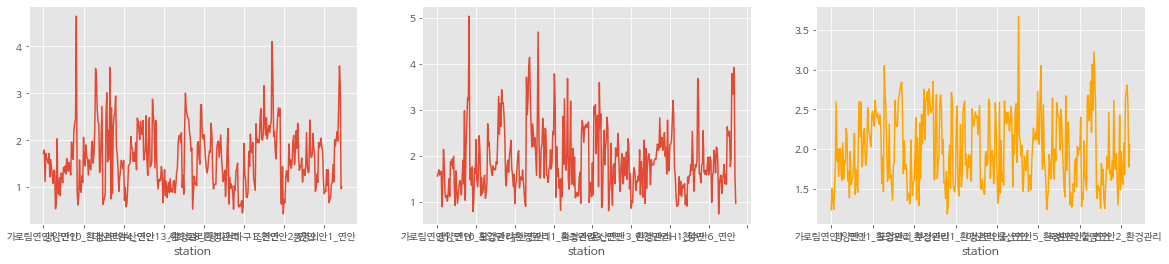

In [ ]:
#좌 2019, 2020 5월 실제 COD 농도 / 우 2021 5월 예측 COD 농도 
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20,4)
df.groupby(['year', 'month', 'station']).mean().loc[2019, 5]['COD'].plot(ax=ax1)
df.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['COD'].plot(ax=ax2)
predict511.groupby(['year', 'month', 'station']).mean().loc[2020, 5]['yhat'].plot(ax=ax3, color = 'orange')

In [ ]:
#이너조인으로 위치 정보만 담긴 데이터프레임에 증감비율 삽입
ud511 = pd.merge(df511.groupby('station').mean().iloc[:,0:2], nt2, left_on='station', right_on='station', how='inner')
ud511 = ud511.sort_values(by=['20-21증감비율'], ascending=False).head(10)

In [ ]:
ud511

,Longitude [degrees_east],Latitude [degrees_north],20-21증감비율
station,,,
부산연안3_환경관리,129.126390,35.146110,212.523324
가막만1_환경관리,127.734170,34.722500,190.611237
고흥연안5_연안,127.479167,34.478333,185.600854
여수연안1_연안,127.766111,34.735556,181.116504
죽변연안3_연안,129.431389,36.974722,165.482335
득량만5_환경관리,127.041110,34.483890,156.577996
부산연안14_환경관리,129.135280,35.159170,136.823034
울산연안3_환경관리,129.398610,35.478060,118.963769
통영외안1_연안,128.131667,34.773611,118.004448


In [ ]:
#Qgis를 위한 export
ud511.to_csv('/content/gdrive/MyDrive/해양/ud511.csv')

In [ ]:
# COD 20-21증감비율 TOP 20 뽑기

m = folium.Map(location=[36.377247, 128.067197], zoom_start=7, prefer_canvas=True)

for i in ud511[['Latitude [degrees_north]', 'Longitude [degrees_east]']].index:
    #if '1' in i:
      #if'2' not in i and '3' not in i and '4' not in i and '5' not in i and '6' not in i and '7' not in i and '11' not in i and '0' not in i:
        #print(i)
    folium.Circle(location=ud511[['Latitude [degrees_north]', 'Longitude [degrees_east]']].loc[i], 
                radius=float(ud511['20-21증감비율'].loc[i])*100, 
                color='red', fill_color='red', fill_opacity=0.2, line_opcity=0.2, 
                tooltip= (i , int(ud511['20-21증감비율'].loc[i])) ).add_to(m)


m

## 결론

In [ ]:
nt.head(10) ## 28월

,20-21증감비율
station,
군산연안5_연안,237.991953
군산연안3_연안,224.292440
목포연안5_연안,188.409366
부산연안3_환경관리,187.051277
목포연안1_연안,169.381439
부산연안8_환경관리,163.784609
광양만9_환경관리,153.410469
목포연안H1_항만,148.850743
부산연안1_환경관리,141.337576


In [ ]:
nt2.head(10) ## 511월

,20-21증감비율
station,
부산연안3_환경관리,212.523324
가막만1_환경관리,190.611237
고흥연안5_연안,185.600854
여수연안1_연안,181.116504
죽변연안3_연안,165.482335
득량만5_환경관리,156.577996
부산연안14_환경관리,136.823034
울산연안3_환경관리,118.963769
통영외안1_연안,118.004448
